<a href="https://colab.research.google.com/github/scrameri/Umweltbiologie/blob/master/Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [7]:
need.pckg <- c("GGally","ggplot2","EnvStats","multcomp") # needed for this script
if (any(!need.pckg %in% installed.packages())) {
  for (i in need.pckg[!need.pckg %in% installed.packages()]) {
    cat("installing", i, "...\n")
    install.packages(i)
  }
}

installing GGally ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘reshape’




installing EnvStats ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘nortest’




installing multcomp ...


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’




### Load libraries

In [8]:
library("GGally") # for ggpairs()
library("ggplot2") # for ggplot()
library("EnvStats") # for qqPlot()
library("multcomp") # for glht()

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


The following object is masked from ‘package:base’:

    print.default


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:EnvStats’:

    boxcox



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




## Data Exploration


***
### Read the data

In [0]:
morph <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Puzzle_ANOVA_LM.csv")

NOTE: the .csv file uses "," rather than ";" as field separators, which can cause troubles when opening the file in Excel on Mac. You can also save a version separated with ";", but you will then need to set `sep=";"`, because the default argument is `read.csv(file, sep = ',')`. Also have a look at the `read.csv2` function.



***
### Get an overview over the dataset
This dataset contains morphological measurements of eight populations of [*Dianthus carthusianorum*](https://www.infoflora.ch/de/flora/dianthus-carthusianorum.html) taken in Summer 2015 in Wallis (Switzerland). Populations were located in two classes of elevation (4 high, 4 low elevation).

A few facts about [*D. carthusianorum*](https://de.wikipedia.org/wiki/Kart%C3%A4usernelke)
- Karthäuser-Nelke in German, family Caryophyllaceae like *Silene*
- native to Middle Europe, in dry habitats from colline to alpine (introduced to N America) 
- [gynodioecious](https://en.wikipedia.org/wiki/Gynodioecy), meaning that there are female and hermaphroditic individuals
- perennial (or biennial), meaning that plants survive winter as rosettes or seeds
- insect-pollinated
- parasite: fungus [*Microbothryum*](https://fr.wikipedia.org/wiki/Microbotryum) *dianthorum* (anther smut fungus) that causes sterility and is transmitted by pollinators

A few facts about the dataset
- ID: individual ID
- Population: population ID
- Elevation: elevation class
- Date: measurement date
- Infection: whether a plant was [infected](https://upload.wikimedia.org/wikipedia/commons/e/ef/Microbotryum_dianthorum_Dianthus_sp._2019_07_18_05.jpg) or healthy
- Sex: whether a plant was hermaphroditic or female
- Stalk_height: mean stalk height per plant (mm)
- Stalk_count: number of stalks per plant
- Bud_count: number of buds per plant
- Flower_count: number of open flowers per plant
- Flower_diam: flower (corolla) diameter (mm)
- Petal and Sepal lengths and widths (mm)
- Rosette_diam1: diameter of first rosette (mm) - only recorded at high elevation
- Rosette_diam2: diameter of second rosette (mm) - only recorded at high elevation

The experimental design and measurements have been done by [Ursina Walther](https://peg.ethz.ch/people/person-detail.html?persid=158239) (a PhD student in our group). She was interested in studying the evolution of floral traits in this species, especially in relation to the interaction between the plants and their Microbothryum parasite.

Before starting any analysis, always check that the data was read in *correctly*.

In [31]:
str(morph) # lists all variables in the data.frame and their classes
ncol(morph)

'data.frame':	123 obs. of  17 variables:
 $ ID           : Factor w/ 123 levels "Fald_inf_1","Fald_inf_2",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Population   : Factor w/ 8 levels "Faldumalp","Gibidumsee",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Elevation    : Factor w/ 2 levels "high","low": 1 1 1 1 1 1 1 1 1 1 ...
 $ Date         : Factor w/ 7 levels "10.7.2015","4.8.2015",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Infection    : Factor w/ 2 levels "healthy","infected": 2 2 2 2 2 2 1 1 1 1 ...
 $ Sex          : Factor w/ 2 levels "female","hermaphroditic": 2 2 2 2 2 2 2 2 2 2 ...
 $ Stalk_height : num  176 112 173 161 165 ...
 $ Stalk_count  : int  2 5 3 3 1 2 7 16 9 3 ...
 $ Bud_count    : int  5 0 4 3 4 4 1 4 4 3 ...
 $ Flower_count : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Flower_diam  : num  14.1 14 12.8 13.3 14.8 13.2 17 14.6 17.3 11.2 ...
 $ Petal_length : num  5.6 5.3 6.3 4.8 6.5 7.2 8.2 7.7 7.7 4.4 ...
 $ Petal_width  : num  6.6 6.5 5.4 6.4 7.3 7.5 10.1 6 8.6 6.4 ...
 $ Sepal_length : num  12.9 12.6 11.9 13.2 14.

[1] 17

In [29]:
dim(morph) # gives both nrow() and ncol() of the dataset


[1] 123  17

In [30]:
summary(morph$Stalk_height) # gives a summary for one variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   28.2   136.4   212.0   256.7   380.0   670.0 

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
 Based on what you now know about the study and the data:
- what are the response variable(s)?
- what are the explanatory variable(s)?

***

### Plot the data
There are various plotting techniques to visualize data. Some people prefer the `R` base graphics, others learn the grammar of graphics implemented in [`ggplot2`](https://ggplot2.tidyverse.org/). For this practical, both approaches can be used. These are the basic functions for the most important plots, shown for `R` base graphics and `ggplot2` graphics:

Use **Scatterplots** to plot two numeric variables (classes `num` for continuous, or `int` for discrete data) against each other. Scatterplots can be more informative if different *symbols* or *colours* for an additional factor, or *sizes* or *transparency* for an additional numeric variable are used.

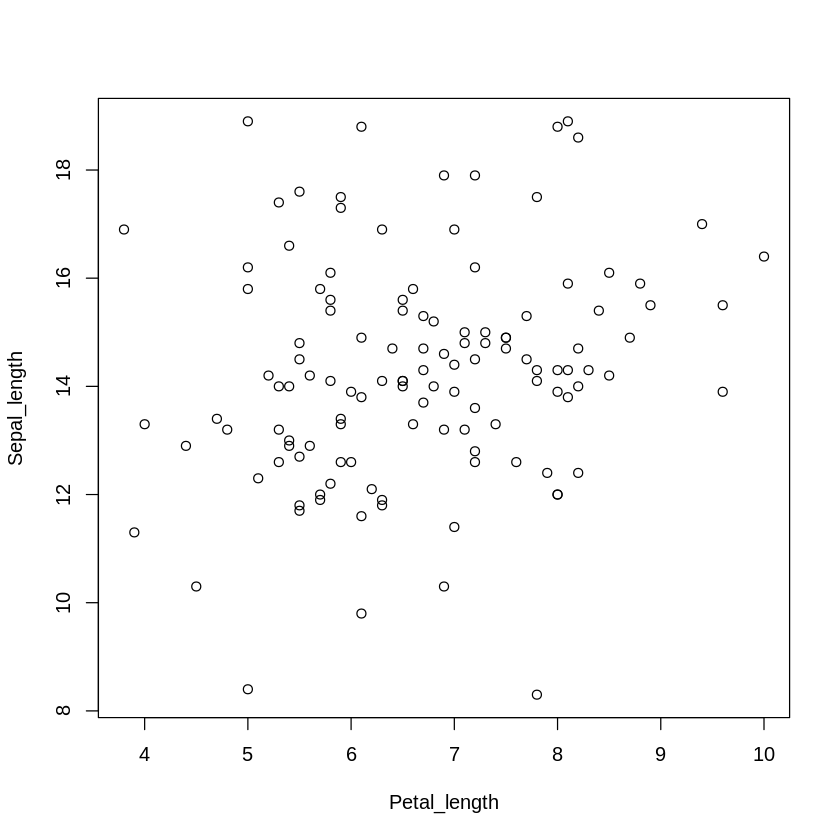

In [0]:
# base
plot(Sepal_length ~ Petal_length, data = morph)

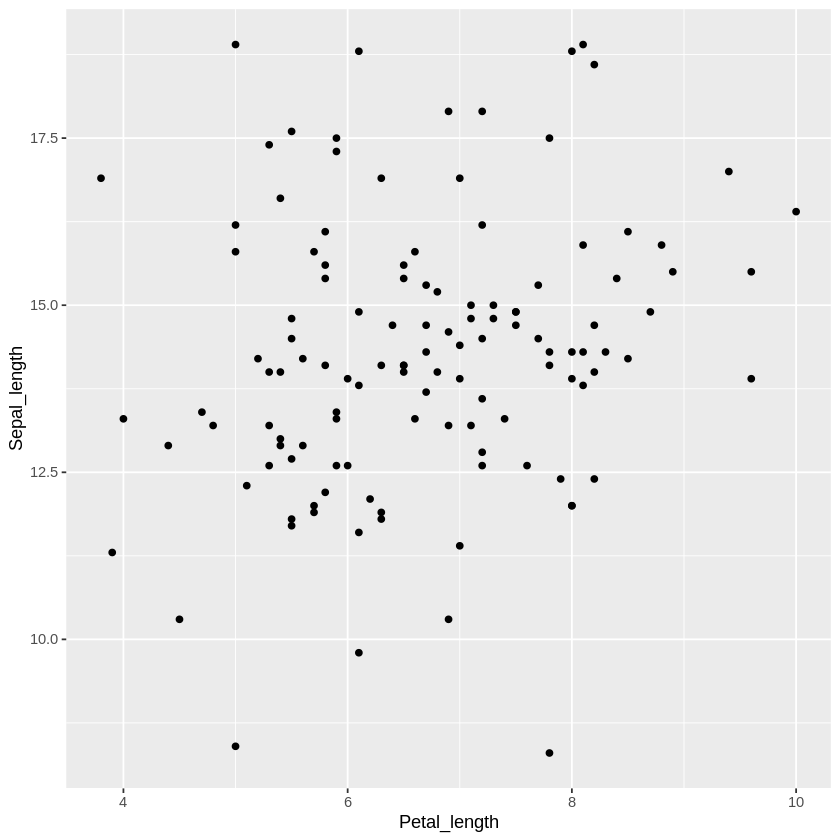

In [0]:
# ggplot2
ggplot(data = morph, aes(x = Petal_length, y = Sepal_length)) + geom_point()

Use **Boxplots** to plot a numeric variable against a categorical variable (class `factor`). Boxplots are summarizing the data. By default, the box is the *interquartile range* and contains 50% of the data points, while the whiskers extend to "the most extreme data point which is no more than 1.5 times the interquartile range from the box" (see cell 85). If you have less than eight data points per factor level, you might just aswell plot all the data points using `stripchart(Sepal_length ~ Elevation, data = morph, vertical = TRUE)`.

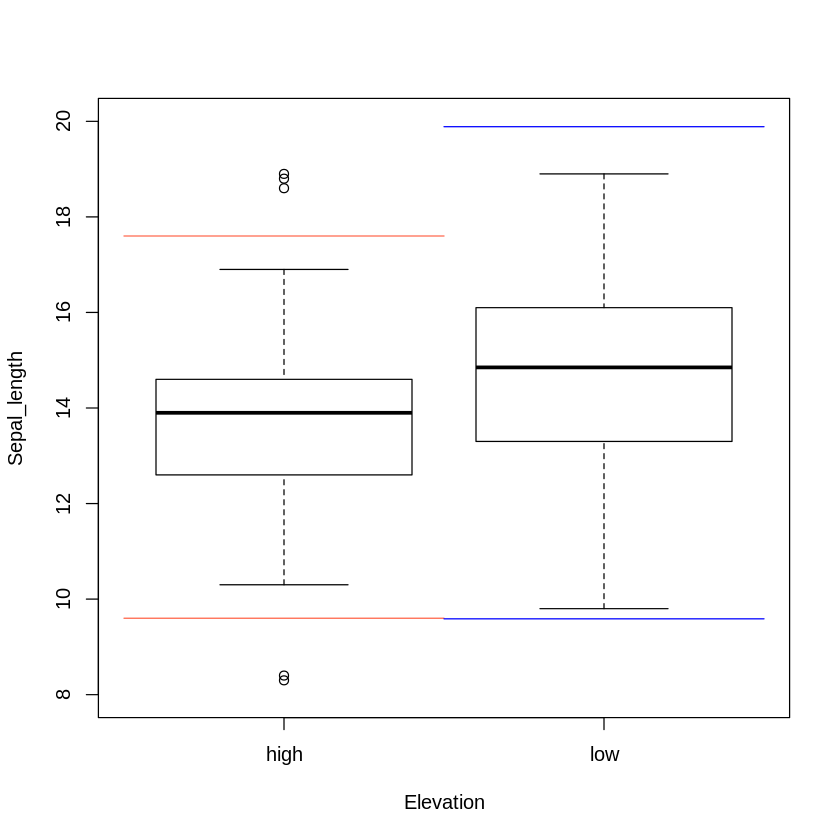

In [0]:
# base
boxplot(Sepal_length ~ Elevation, data = morph, ylim = c(8,20))

# understand interquartile range (iqr): range from 25% to 75% quantiles, contains 50% of the data
iqr1 <- quantile(morph$Sepal_length[morph$Elevation=="high"], c(0.25,0.75))
iqr2 <- quantile(morph$Sepal_length[morph$Elevation=="low"], c(0.25,0.75))

# whiskers extend to the most extreme data point not exceeding 1.5*iqr from the box (by default)
whisker1 <- iqr1 + c(-1.5,1.5)*diff(iqr1)
whisker2 <- iqr2 + c(-1.5,1.5)*diff(iqr2)

segments(0.5, whisker1, 1.5, whisker1, col = "tomato")
segments(1.5, whisker2, 2.5, whisker2, col = "blue")

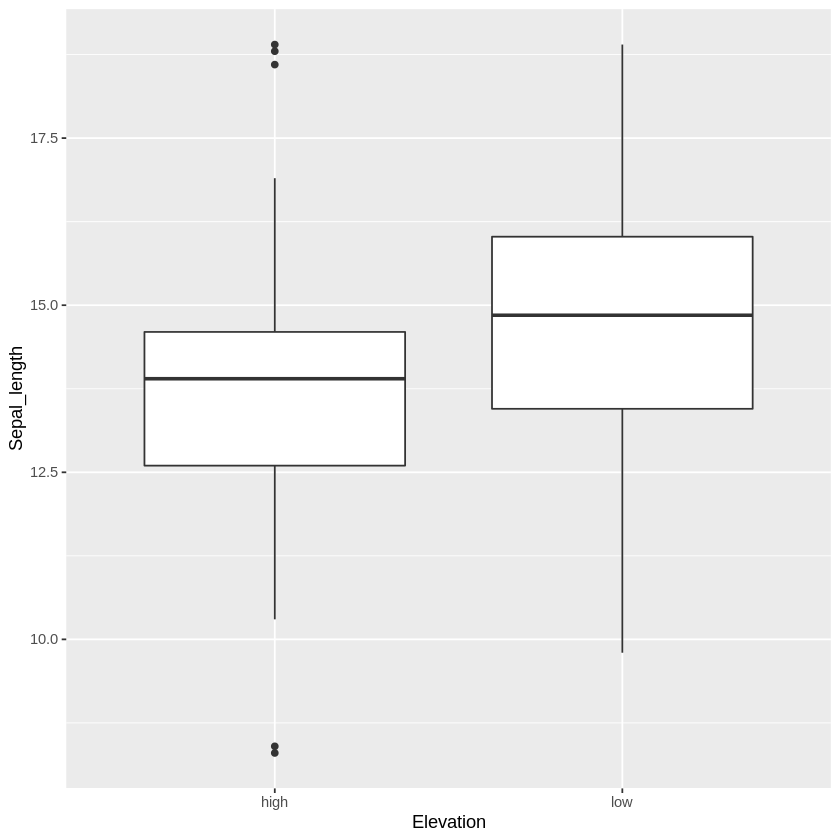

In [0]:
# ggplot2
ggplot(data = morph, aes(x = Elevation, y = Sepal_length)) + geom_boxplot()

Use **Histograms** to plot a variable's distribution. The `breaks` argument in `hist` and the `bins` argument in `geom_histogram` can be used to fine-tune the binning of values into histogram categories. Try and play around with it.

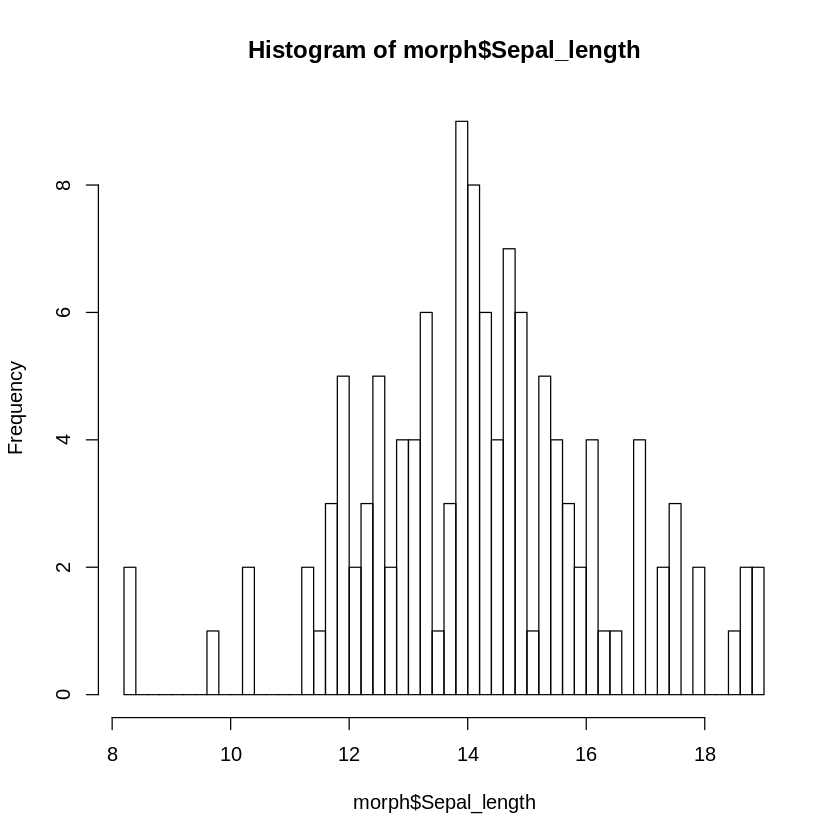

In [0]:
hist(morph$Sepal_length, breaks = 20)

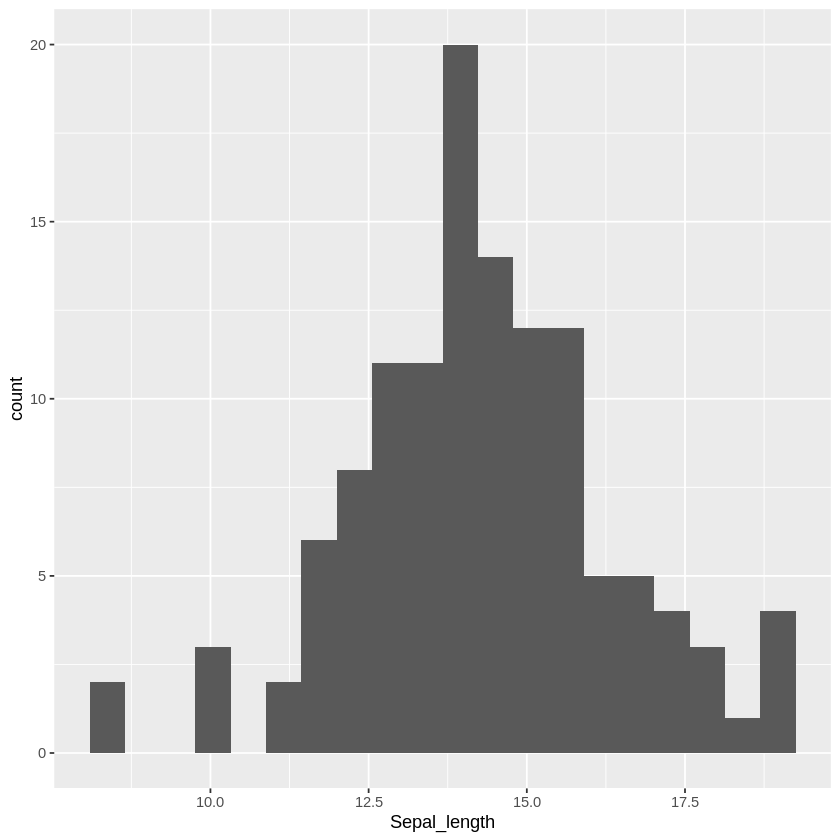

In [0]:
ggplot(data = morph, aes(x = Sepal_length)) + geom_histogram(bins = 20) 

Use **Barplots** to plot all values of a single variable or a table of counts.

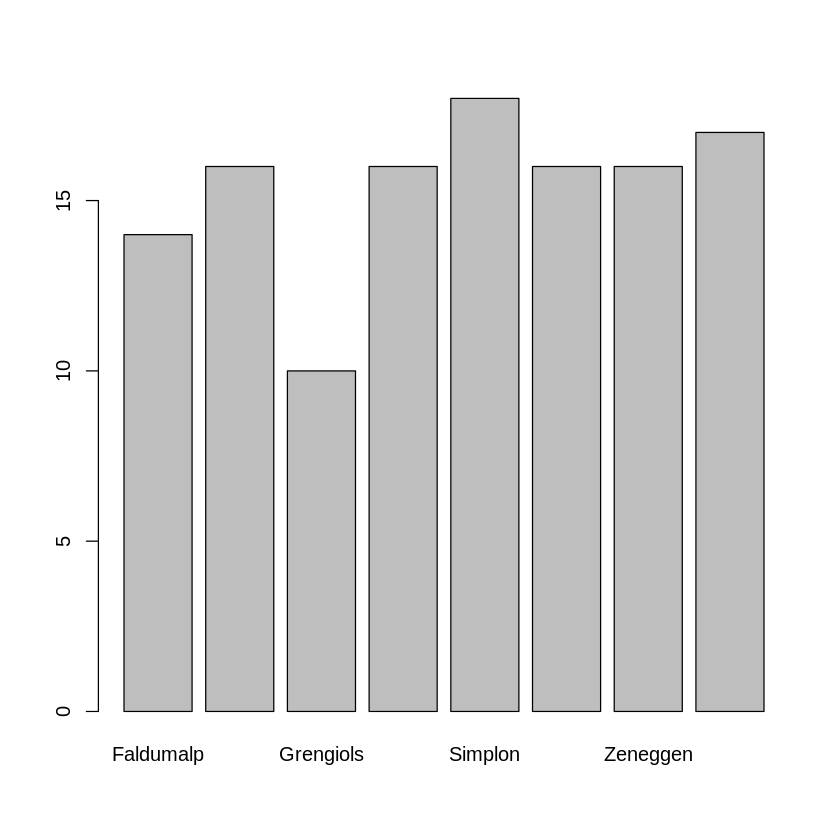

In [0]:
# base
barplot(table(morph$Population))

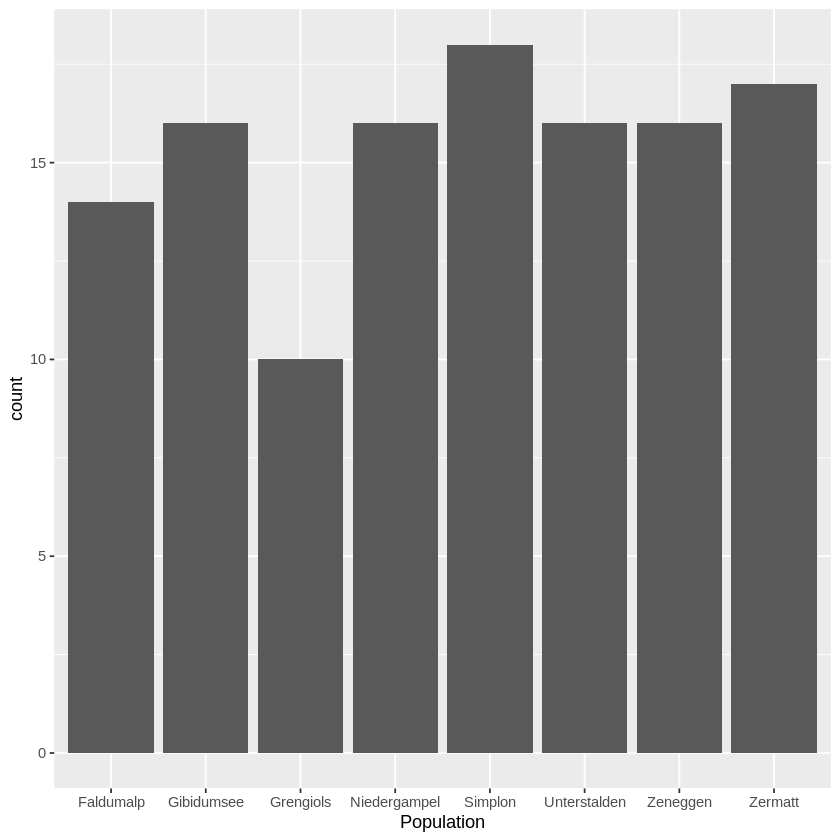

In [0]:
# ggplot2 (uses count table by default!)
ggplot(data = morph, aes(x = Population)) + geom_bar(stat = "count")

Use **Mosaic Plots** or **Stacked Barplots** to plot *contingency tables* of two categorical variables against each other. In a Mosaic Plot, the relative size of each mosaic is proportional to the number of observations with a given factor level combination. The stacked barplot is slightly different, once shown as stacked *counts* and once as stacked *proportions*.

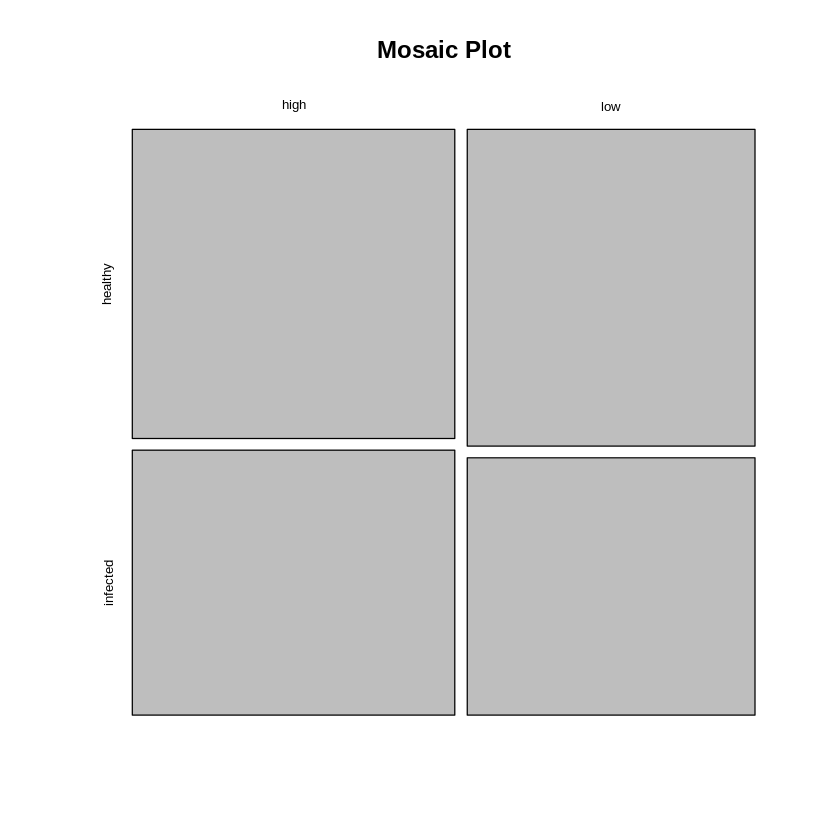

In [0]:
# base
mosaicplot(table(morph$Elevation,morph$Infection), main = "Mosaic Plot")

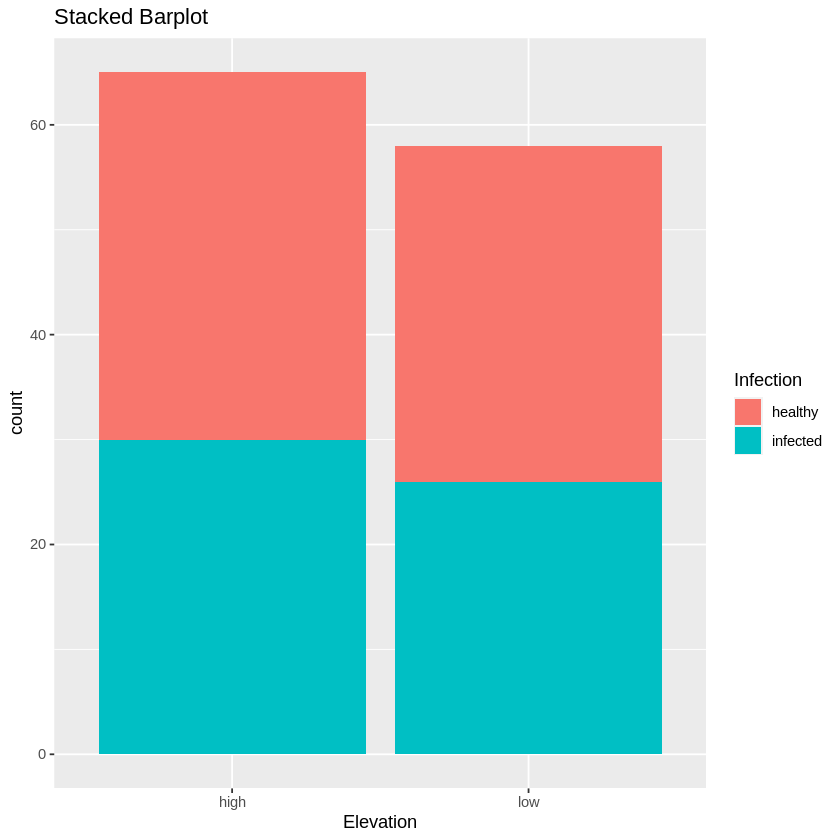

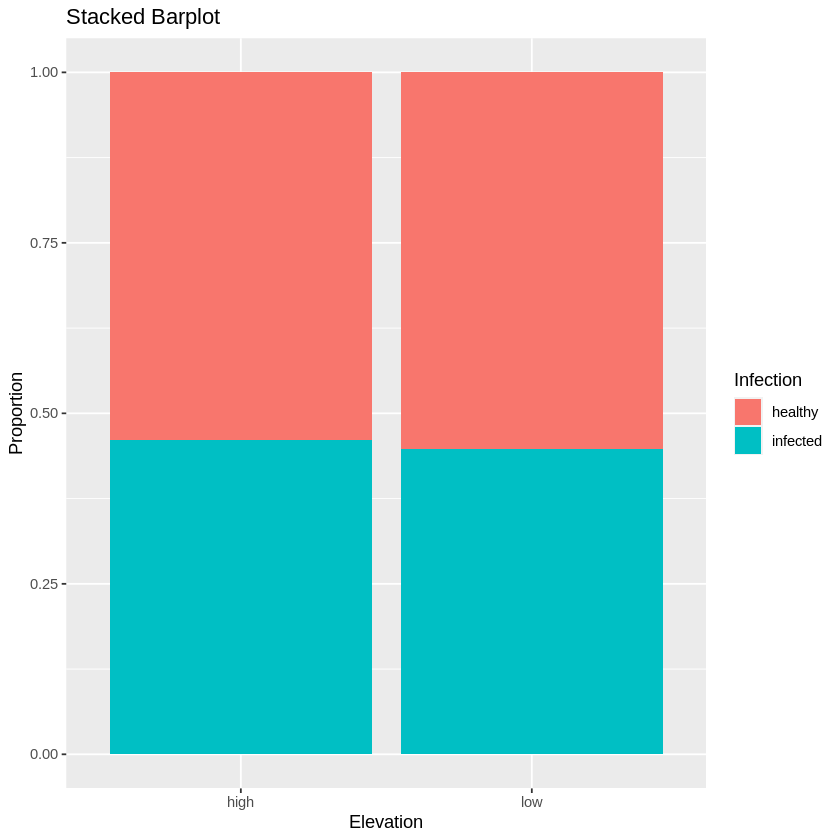

In [0]:
# ggplot2 (fill variable determines the stacking)
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar() + 
  ggtitle("Stacked Barplot")
  
ggplot(morph, aes(x = Elevation, fill = Infection)) + 
  geom_bar(position = "fill") + labs(y = "Proportion") +
  ggtitle("Stacked Barplot")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you produce a plot of `Petal_length ~ Sepal_length` with points color-coded for `Infection` and size proportional to `Petal_length`?


In [0]:
# Make your plot here

***
### Generate all pairwise plots
#### Use regular expressions
Given that we have 17 variables, plotting all of them against each other by hand would be tedious. For datasets with a moderate number of variables, you can use the `ggpairs` function from the [*GGally*](https://cran.r-project.org/web/packages/GGally/index.html) package to get a graphical overview over many variables at once with a single line of code. The function produces all possible pairwise plots, minimizes redundancy and takes care of factors and numerical variables automatically.

With 17 variables, plotting all against all would lead to too many (289) plots on a single page. Let us therefore subset the variables. You can use `grep` and [**regular expressions**](https://regex101.com/) to find the indices of certain variable names, this often saves code.

In [0]:
# this returns the index of variable names *starting* with 'Flower' (^ specifies the *start*)
grep(pattern = "^Flower_", x = names(morph))

[1] 10 11

In [0]:
# this returns the index of variable names *ending* with either 'length' or 'width' ($ specifies the *end*, | is a logial <or>)
grep(pattern = "length$|width$", x = names(morph)) 


[1] 12 13 14 15

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you identify the indices of columns with variables of *fertile* structures (buds, flowers) using a regular expression?

In [0]:
# Create your regular expression here
names(morph)
grep(pattern = "XXX", x = names(morph))

[1] "ID"            "Population"    "Elevation"     "Date"         
 [5] "Infection"     "Sex"           "Stalk_height"  "Stalk_count"  
 [9] "Bud_count"     "Flower_count"  "Flower_diam"   "Petal_length" 
[13] "Petal_width"   "Sepal_length"  "Sepal_width"   "Rosette_diam1"
[17] "Rosette_diam2"

integer(0)

#### print all pairwise plots

In [122]:
print(vars.fertile <- names(morph)[grep(pattern = "^Flower|^Bud|^Petal|^Sepal", x = names(morph))])
print(vars.sterile <- names(morph)[grep(pattern = "^Stalk|^Rosette", x = names(morph))])

[1] "Bud_count"    "Flower_count" "Flower_diam"  "Petal_length" "Petal_width" 
[6] "Sepal_length" "Sepal_width" 
[1] "Stalk_height"  "Stalk_count"   "Rosette_diam1" "Rosette_diam2"


The `ggpairs` function prepares the pairwise plots as `gg` class objects. These can then be printed to the plotting device, or saved to a PDF file by enclosing the print commands between the `pdf` and `graphics.off` functions.

It is more reproducible (and therefore more scientific) to save plots with such code rather than by manually exporting a plot from R Studio. The specified `height` and `width` also prevents the saved plot to be smaller or larger depending on your device size.

In [0]:
pairs.fertile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.fertile))
pairs.sterile <- ggpairs(data = morph, columns = c("Population","Elevation","Infection","Sex", vars.sterile))

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing

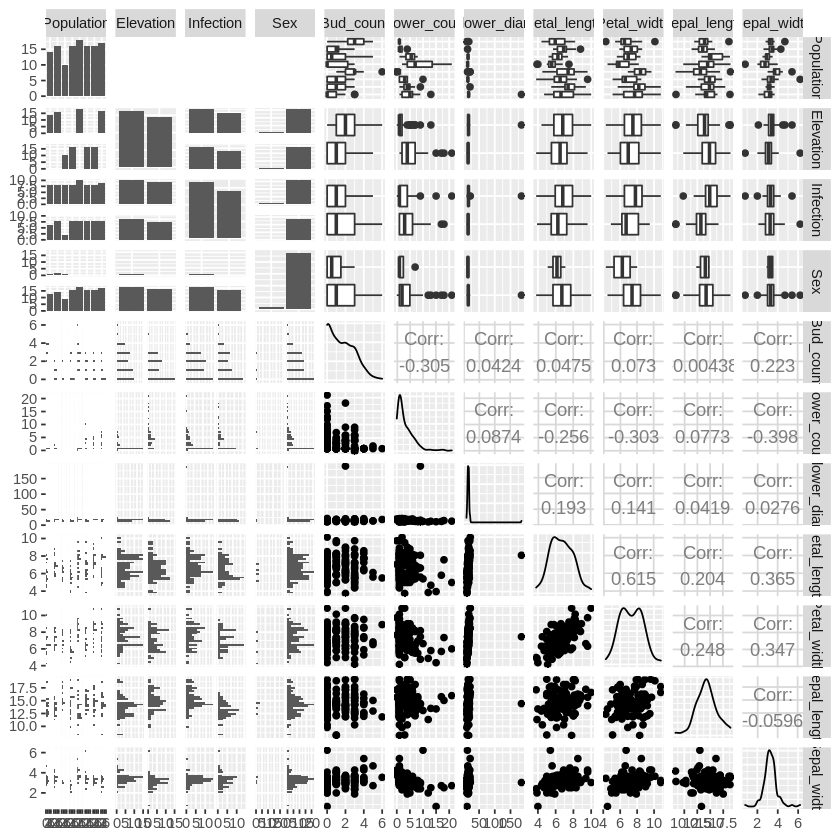

In [124]:
#pdf("Pairsplots.pdf", height = 15, width = 15)
#pairs.sterile # or print(pairs.sterile)
pairs.fertile # or print(pairs.fertile)
#graphics.off()

Does everything look all right?




***
### Transparent data fixes
If there are obvious data errors, do not manually change the original data. Rather think carefully what the issue might be, and if you can be sure enough, make the data changes in the analysis script, such that fixes become **transparent** and **reproducible**. If you cannot reconstruct what happened with an impossible data value, you should set it to `NA` or remove the entire data row in the analysis script.

In [24]:
morph$Flower_diam[morph$Flower_diam > 100] # Dianthus with 185 mm flower diameter is impossible
morph$Flower_diam[morph$Flower_diam > 100] <- morph$Flower_diam[morph$Flower_diam > 100]/10 # if you are sure it is a comma-error
# morph$Flower_diamesser[morph$Flower_diamesser > 100] <- NA # if you cannot be sure what happened


[1] 185

***

### Check the distribution of your variables
Knowing the distribution of your variables is important, especially if you want to create models of them that make certain assumptions on distributions. You have already seen that the **histogram** is a good visualization of a variable's distribution because deviations from a normal distribution become intuitively apparent.

Let us look at `Stalk_count`, which is a count variable and therefore by definition bound by zero on the left, and unbounded on the right. Such *right-skewed* distributions are not normally distributed.

But which statistical distribution is best at describing your data if not a normal distribution? Knowing this would be helpful, e.g. to define an appropriate error distribution in a generalized linear model. **Simulations** can help you to compare your data against data from a specific statistical distribution. The `R` package [*EnvStats*](https://cran.r-project.org/web/packages/EnvStats/index.html) allows for simulation of different probability distributions from your data, and comparison of these against your data in so-called **Q-Q Plots** (Quantile-Quantile plots).

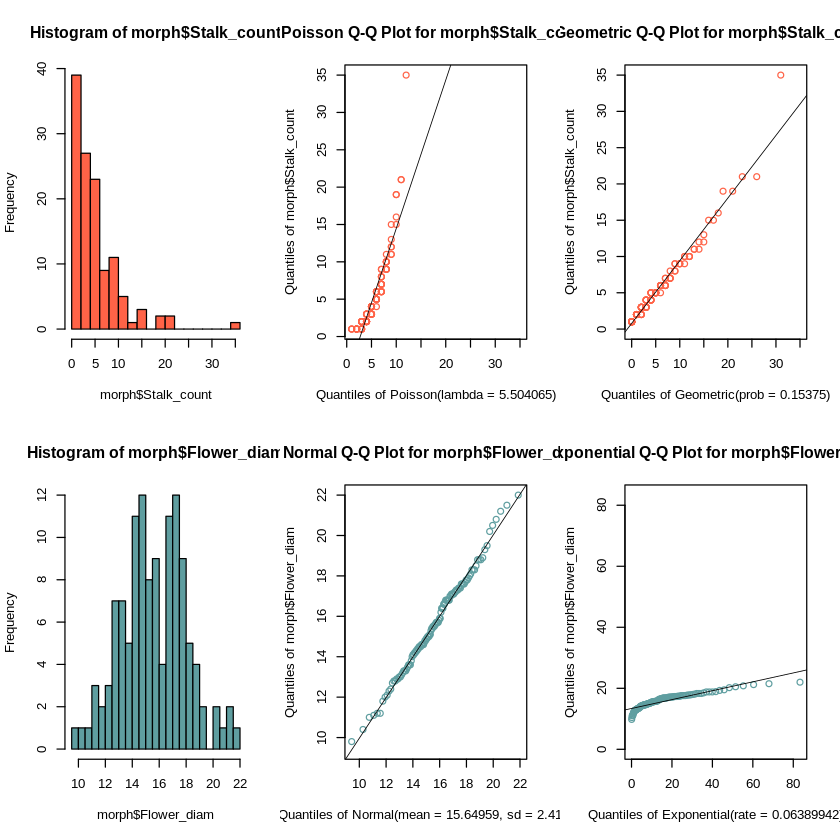

In [29]:
# see ?EnvStats::Distribution.df for a list comprehensive list of continuous and discrete distributions
par(mfrow=c(2,3))
hist(morph$Stalk_count, breaks = 20, col = "tomato")
qqPlot(morph$Stalk_count, distribution = "pois", estimate.params = TRUE, add.line = TRUE, points.col = "tomato")
qqPlot(morph$Stalk_count, distribution = "geom", estimate.params = TRUE, add.line = TRUE, points.col = "tomato")
hist(morph$Flower_diam, breaks = 20, col = "cadetblue")
qqPlot(morph$Flower_diam, distribution = "norm", estimate.params = TRUE, add.line = TRUE, points.col = "cadetblue")
qqPlot(morph$Flower_diam, distribution = "exp", estimate.params = TRUE, add.line = TRUE, points.col = "cadetblue")
par(mfrow=c(1,1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Which probability distribution is best at describing `Stalk_count`? 
- Which probability distribution is best at describing `Flower_diam`? 
- What does this mean for an ANOVA model `Stalk_count ~ Elevation` fitted to this data?

***

## Analysis of Variance and Linear Models

### The relationship between t-test, ANOVA and linear models

**Analysis of Variance (ANOVA)** using `aov` and (generalized) **linear models** using `lm`or `glm` are closely related to each other and differ mainly in *intent* of analysis and default *presentation* of results. If you read the aov help page, you will see that `aov` actually calls `lm`, so both rely on the same [least squares](https://en.wikipedia.org/wiki/Least_squares) method.


You can think of ANOVA and linear models as extensions of a two-sample [**t-test**](https://en.wikipedia.org/wiki/Student%27s_t-test) that allow for tests of more factors or covariates at once. Remember that the two-sample t-test allows to test the difference in a dependent variable (a.k.a. **response** variable, measure variable, Y variable) between two levels of one factor (a.k.a. **predictor** variable, independent variable, X variable). An example two-sample t-test is the test for difference in human height (the response variable) between two sexes (the predictor variable). 

Let us start with a **one-sample t-test**:

In [0]:
t.test(morph$Sepal_length, mu = 0)


	One Sample t-test

data:  morph$Sepal_length
t = 77.368, df = 122, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 13.91985 14.65088
sample estimates:
mean of x 
 14.28537 


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the test result?

This test can also be accomplished using `lm`:

In [0]:
summary(lm(Sepal_length ~ 1, data = morph))


Call:
lm(formula = Sepal_length ~ 1, data = morph)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9854 -1.3354 -0.0854  1.1646  4.6146 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  14.2854     0.1846   77.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.048 on 122 degrees of freedom


Let us now extend this to a **two-sample t-test** (one sample at low and one at high elevation):

In [0]:
# complicated syntax, showing the two samples (sepal lengths at high and low elevation)
# t.test(morph$Sepal_length[morph$Elevation == "high"], morph$Sepal_length[morph$Elevation == "low"], data = morph, mu = 0)

# shorter and more elegant formula notation 
t.test(Sepal_length ~ Elevation, data = morph, mu = 0)


	Welch Two Sample t-test

data:  Sepal_length by Elevation
t = -2.8931, df = 119.46, p-value = 0.004535
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.7502608 -0.3279355
sample estimates:
mean in group high  mean in group low 
          13.79538           14.83448 


Again, the same test can be accomplished using `lm` or `aov`. A `summary` on `aov` will give you the **ANOVA table**, while `lm` will give you **effect size** estimates.

In [0]:
cat("**ANOVA table**\n")
summary(aov(Sepal_length ~ Elevation, data = morph))

cat("\n\n**Effect size estimates**\n")
summary(lm(Sepal_length ~ Elevation, data = morph))

**ANOVA table**


             Df Sum Sq Mean Sq F value  Pr(>F)   
Elevation     1   33.1   33.09   8.369 0.00453 **
Residuals   121  478.5    3.95                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



**Effect size estimates**



Call:
lm(formula = Sepal_length ~ Elevation, data = morph)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4954 -1.2954  0.0655  0.9655  5.1046 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   13.7954     0.2467  55.930  < 2e-16 ***
Elevationlow   1.0391     0.3592   2.893  0.00453 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.989 on 121 degrees of freedom
Multiple R-squared:  0.06469,	Adjusted R-squared:  0.05696 
F-statistic: 8.369 on 1 and 121 DF,  p-value: 0.004529


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What are the null and alternative hypotheses? 
- What is the estimated effect size of Elevation?
- How do you interpret the Elevation effect estimate intuitively?


***

### One-way ANOVA and simple linear models

The **one-way ANOVA** allows for comparing more then just two groups (i.e. one treatment factor can have more than two levels). 

Tests with more than 2 levels in a predictor variable can have different intents: 

1. test for an *overall* effect of a factor such as `Population` on calyx length
2. test for an effect of a *specific* factor level, for instance a treatment relative to a *control*, including effect size estimates.

If your goal is 1., then you can use `aov`:

In [38]:
summary(aov1 <- aov(Sepal_length ~ Population, data = morph))

             Df Sum Sq Mean Sq F value Pr(>F)  
Population    7   55.8   7.976   2.013 0.0593 .
Residuals   115  455.8   3.963                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

If your goal is 2., then you can use `lm`. Note that a `summary` on `lm` does not give you an answer to the hypothesis "Population has an effect on Sepal_length", while a `summary` on `aov` does.

In [39]:
summary(lm1 <- lm(Sepal_length ~ Population, data = morph))


Call:
lm(formula = Sepal_length ~ Population, data = morph)

Residuals:
   Min     1Q Median     3Q    Max 
-5.900 -1.194  0.000  1.206  5.550 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             14.0000     0.5321  26.313   <2e-16 ***
PopulationGibidumsee    -0.4187     0.7285  -0.575    0.567    
PopulationGrengiols      1.8000     0.8243   2.184    0.031 *  
PopulationNiedergampel   0.3938     0.7285   0.540    0.590    
PopulationSimplon       -0.6500     0.7094  -0.916    0.361    
PopulationUnterstalden   0.9188     0.7285   1.261    0.210    
PopulationZeneggen       0.5875     0.7285   0.806    0.422    
PopulationZermatt        0.3000     0.7185   0.418    0.677    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.991 on 115 degrees of freedom
Multiple R-squared:  0.1091,	Adjusted R-squared:  0.05491 
F-statistic: 2.013 on 7 and 115 DF,  p-value: 0.0593


Irrespective of whether you fitted a model with `aov` or `lm`, you can use some handy accessor functions to **extract key model results**.

In [48]:
## model parameter estimates in coef()
print(coef(lm1))

           (Intercept)   PopulationGibidumsee    PopulationGrengiols 
              14.00000               -0.41875                1.80000 
PopulationNiedergampel      PopulationSimplon PopulationUnterstalden 
               0.39375               -0.65000                0.91875 
    PopulationZeneggen      PopulationZermatt 
               0.58750                0.30000 


In [49]:
## confidence interval (by default 95%) for model parameter estimates in confint()
print(confint(aov1,  level = 0.95))

                            2.5 %     97.5 %
(Intercept)            12.9461040 15.0538960
PopulationGibidumsee   -1.8618565  1.0243565
PopulationGrengiols     0.1673114  3.4326886
PopulationNiedergampel -1.0493565  1.8368565
PopulationSimplon      -2.0551946  0.7551946
PopulationUnterstalden -0.5243565  2.3618565
PopulationZeneggen     -0.8556065  2.0306065
PopulationZermatt      -1.1231613  1.7231613


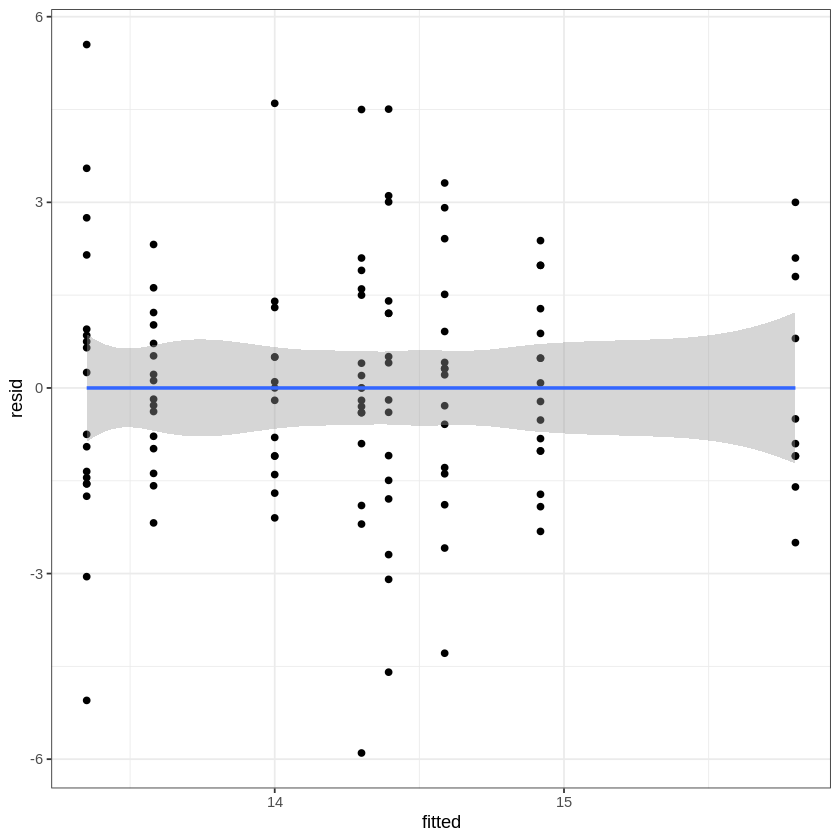

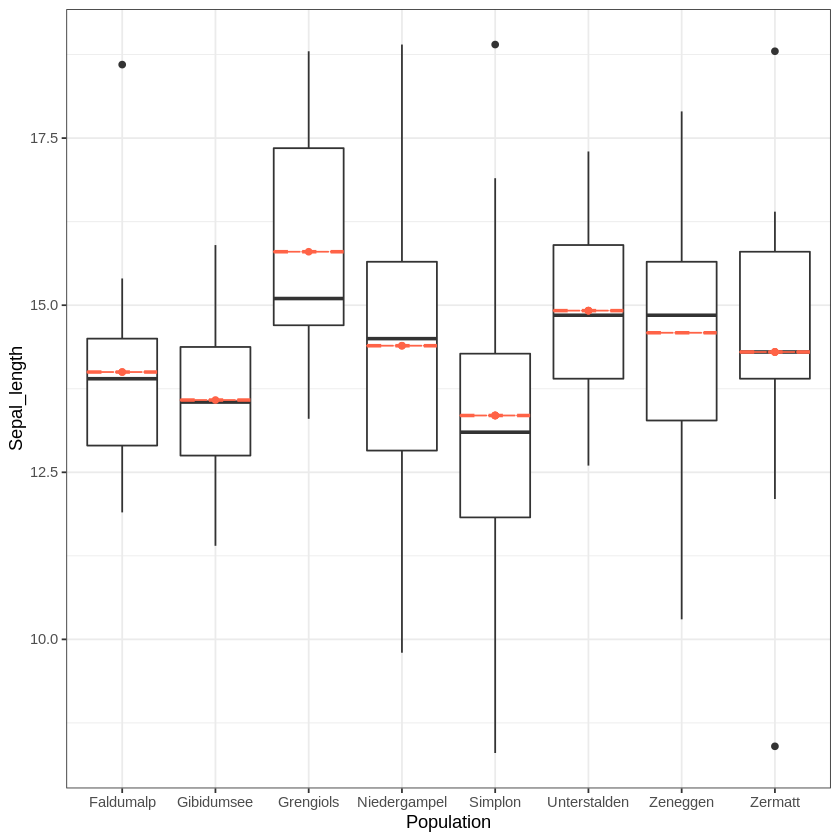

In [184]:
# Tukey-Anscombe plot (see paragraph on Residual Analysis)
dfit <- data.frame(resid = resid(lm1), fitted = fitted(lm1))
ggplot(dfit, aes(fitted, resid)) +
  geom_point() +
  geom_smooth(method = "loess", formula = y ~ x) +
  theme_bw()

# Observed values in black, fitted values in red
ggplot(morph, aes(Population, Sepal_length)) + 
  geom_boxplot() + 
  geom_boxplot(aes(Population, fitted(lm1)), col = "tomato", linetype = 2) +
  theme_bw()

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Why are there only 7 estimates of population model parameters instead of 8?
- Can you tell from the **confidence intervals** which population(s) are significantly different from the reference population?

***

### Multi-way ANOVA and multiple linear regression
There are many extensions to one-way ANOVA and simple linear models. In `R`, you can use the same functions `aov` and `lm` (or `glm`) and provide them with a more complex model. 

The **Factorial ANOVA** extends the one-way ANOVA to test >1 predictors (each with two or more levels), including interactions.

The **mathematical model** for two predictors without interaction is as follows:
* Y = β<sub>0</sub> + β<sub>1</sub>\*X<sub>1</sub> + β<sub>2</sub>\*X<sub>2</sub> + E ; E ~ norm(0, sd) i.i.d.

Y, X<sub>1</sub>, and X<sub>2</sub> are given. The model fitting consists of estimating distributions for β<sub>0</sub>, β<sub>1</sub> and β<sub>2</sub>
while minimizing the error term E (approximated by the so-called residuals).

The corresponding **model formula** in `R` is as follows (no need to specify intercept and error term):

* `Y ~ X1 + X2`

Three preditors, the second nested in the first:
* `Y ~ X1/X2 + X3`

Three predictors, two of them interacting:
* `Y ~ X1 + X2 + X1:X2 + X3`
* `Y ~ (X1 + X2)^2 + X3`

Three predictors, include all two-way interactions:
* `Y ~ X1 + X2 + X1:X2 + X1:X3 + X2:X3`
* `Y ~ (X1 + X2 + X3)^2`

Three predictors, include all three-way interactions (rarely used):
* `Y ~ (X1 + X2 + X3)^3`


Beware of the use of highly **correlated predictor variables**. If such are present, the inference can be quite wrong when both are included in the model, as shown in the following example.

correlation between x1 and x2
[1] 0.9875584


=>model with only x1 included


Call:
lm(formula = y ~ x1, data = dsim)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9339 -1.3689  0.0262  1.5024  6.0143 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.03538    0.09232   32.88   <2e-16 ***
x1           3.20039    0.09198   34.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.064 on 498 degrees of freedom
Multiple R-squared:  0.7085,	Adjusted R-squared:  0.708 
F-statistic:  1211 on 1 and 498 DF,  p-value: < 2.2e-16




=>nmodel with only x2 included


Call:
lm(formula = y ~ x2, data = dsim)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5213 -1.3863  0.0738  1.3963  5.1113 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.10776    0.12572  -0.857    0.392    
x2           1.00918    0.02788  36.203   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.006 on 498 degrees of freedom
Multiple R-squared:  0.7247,	Adjusted R-squared:  0.7241 
F-statistic:  1311 on 1 and 498 DF,  p-value: < 2.2e-16




=> model with x1 and x2 included (both highly correlated)


Call:
lm(formula = y ~ x1 + x2, data = dsim)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5217 -1.4103  0.0703  1.4178  5.1605 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.04975    0.55987   0.089    0.929    
x1           0.16429    0.56904   0.289    0.773    
x2           0.95859    0.17743   5.403 1.02e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.008 on 497 degrees of freedom
Multiple R-squared:  0.7247,	Adjusted R-squared:  0.7236 
F-statistic: 654.2 on 2 and 497 DF,  p-value: < 2.2e-16


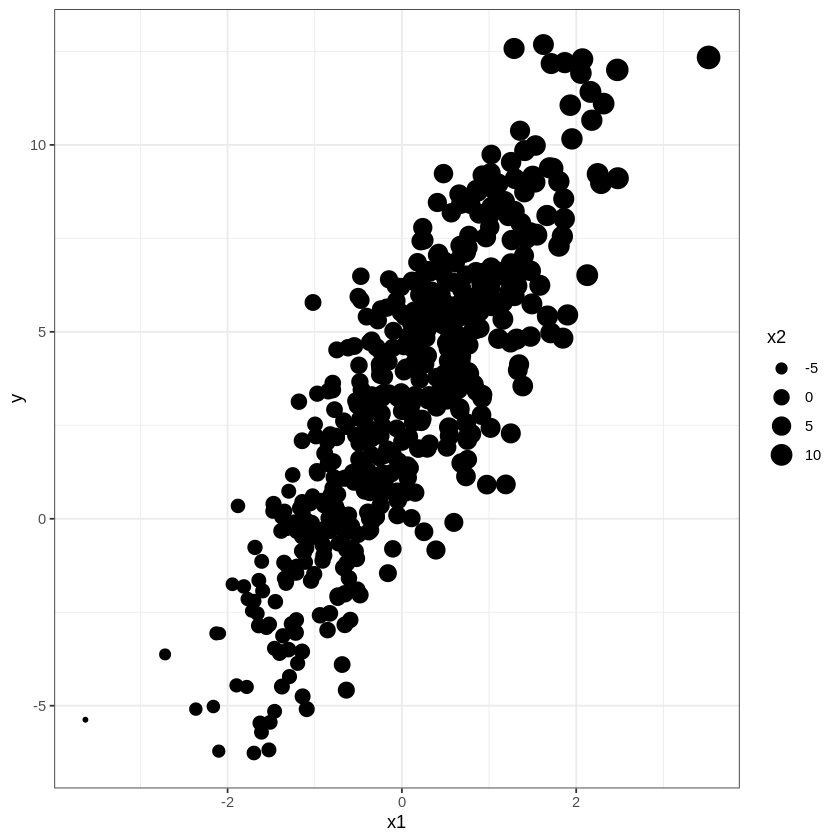

In [158]:
# simulate dataset with highly correlated x1 and x2 (both correlated with y)
x1 <- rnorm(n = 500, mean = 0, sd = 1)
x2 <- pi + pi*x1 + rnorm(n = 500, mean = 0, sd = 0.5)
y  <- x2 + rnorm(n = 500, mean = 0, sd = 2)

dsim <- data.frame(y = y, x1 = x1, x2 = x2)

# correlation among x1 and x2
cat("correlation between x1 and x2\n")
print(cor(dsim$x1, dsim$x2))

# model summaries
cat("\n\n=>model with only x1 included")
summary(lm(y ~ x1, data = dsim))

cat("\n\n=>nmodel with only x2 included")
summary(lm(y ~ x2, data = dsim))

cat("\n\n=> model with x1 and x2 included (both highly correlated)")
summary(lm(y ~ x1 + x2, data = dsim))

# graph
ggplot(dsim, aes(x1, y, size = x2)) + geom_point() + theme_bw()

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- What can you do to prevent the above problem?

***

### ANCOVA and GLMs

The **ANCOVA** (Analysis of Covariance) allows for the mixed use of numerical and categorical predictors. **Generalized linear models** (GLMs) extend ANCOVA by allowing for non-normal error distribution (logistic regression, poisson regression, ...):

Logistic regression
* E ~ Binom(k|p,n) i.i.d

Poisson regression
* E ~ Poisson(lambda) i.i.d.

***
### Interactions
Interactions between predictor (explanatory) variables can be present, and including them in a model can *greatly* improve the model fit and hence the reliability of test results.

An **interaction** occurs if the effect of variable A on the response Y *depends* on variable B.

Example:
You want to model reaction time as Y ~ A + B

* Y = time needed to start breaking after an obstacle appears on the street
* A = amount of coffee drunk 
* B = amount of whisky drunk 

A has a negative effect on reaction time (i.e., more coffee, less reaction time), while B has a positive effect on reaction time (i.e, more whisky, more reaction time).

You can increase coffee consumption to shorten reaction time, but this effect will depend on the amount of whisky drunk. That is, the amount of coffee *interacts* with the amount of whisky.


`R` implements some methods to visualize potential interactions. The idea is to visualize the mean (or other summary) value of the `response` Y at different levels of an explanatory variable of interest (`x.factor`), depending on the level of another and potentially interacting explanatory factor (`trace.factor`).

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to test the effect of `Infection` and `Altitude` on `Petal_length`. Before you fit any model, make sure to plot the data to get a better feeling for it.

In [0]:
## Make a clever plot(s) that shows Petal_legnth, Infection and Altitude

`Petal_length` appears to be lower in some infected individuals, but that does not seem to be the case in low `Elevation` habitats. That is, the effect of `Infection` on `Petal_length` appears to *depend* on `Elevation`. Or in other words: `Infection` and `Elevation` likely *interact*.

The following plot visualizes potential interactions. If the lines cross, the factors strongly interact and you would need to test for the interaction term in any model of `Petal_Length`.

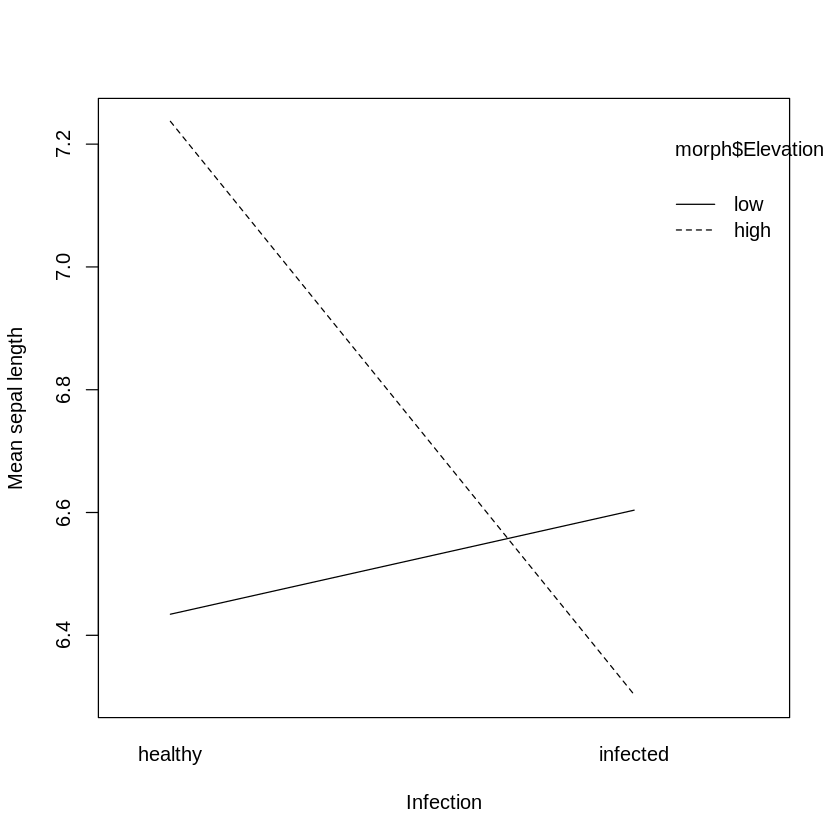

In [0]:
interaction.plot(x.factor = morph$Infection, trace.factor = morph$Elevation, response = morph$Petal_length, 
                 fun = mean, xlab = "Infection", ylab = "Mean sepal length")

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
We now want to formally test for the effect of `Infection` and `Elevation` (including their potential interaction) on `Petal_length`, and estimate the effect sizes.
* which function do you use (`aov` or `lm`)?
* which formula do you use?
* what are the test results?

In [31]:
## Create your model here
summary(mod1 <- lm(Petal_length ~ Infection * Elevation, data = morph))


Call:
lm(formula = Petal_length ~ Infection * Elevation, data = morph)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.83714 -0.93576 -0.03714  0.86424  2.99615 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      7.2371     0.2081  34.771  < 2e-16 ***
Infectioninfected               -0.9338     0.3064  -3.048  0.00284 ** 
Elevationlow                    -0.8028     0.3012  -2.665  0.00876 ** 
Infectioninfected:Elevationlow   1.1033     0.4467   2.470  0.01494 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.231 on 119 degrees of freedom
Multiple R-squared:  0.08694,	Adjusted R-squared:  0.06392 
F-statistic: 3.777 on 3 and 119 DF,  p-value: 0.01246


***

### Check model assumptions via Residual Analysis
Up to now, we have just blindly executed `summary` on `aov` and `lm` fits and interpreted the test results. In practice, this is **not sufficient**.

In order to validate the model, we need to check that the model assumptions are met, or at least not grossly violated.

ANOVA and linear regression models both make the following main **assumptions**:
  
* [**Normality:**](https://en.wikipedia.org/wiki/Normal_distribution) For any fixed value of X, Y is *normally distributed*. This implies that the *residuals* are normally distributed. However, it does not mean that all variables have to be normally distributed (not even within groups).
* [**Homoscedasticity:**](https://en.wikipedia.org/wiki/Homoscedasticity) The *residual variance* is *constant* (the same for any value of X)
* [**Independence:**](https://en.wikipedia.org/wiki/Independence_(probability_theory)) Observations are *independent* of each other (i.e. one measurement is not influenced by another)

If one or more of these assumptions (see this [link](http://r-statistics.co/Assumptions-of-Linear-Regression.html) for more details) are **violated**, you **cannot have trust in your test results** and in any conclusions drawn from them.

You can check most assumptions by applying the generic `plot` function on your model fit. Since this will give you **four diagnostic plots**, it is best to divide the plotting device into four panels using `par`.

The first plot (**Tukey-Anscombe Plot**) is good to check for the assumption of *constant variance* of the residuals. This assumption is violated if there is a funnel-shape ur U-shaped distribution.

The second plot (**Normal Q-Q Plot**) is good to check for the assumption of *normality* of the residuals. If the points follow the diagonal, they follow a normal distribution. If you don't trust your eye, you can also formally test the null hypothesis of normality using a **Shapiro-Wilk normality test** using `shapiro.test` on the model residuals. If that test turns out significant (p < 0.05), it means that the null hypothesis of normality is rejected, and hence that the residuals are not normally distributed.

The **Scale-Location Plot** is similar to the Tukey-Anscombe Plot but plots the square-root of absolute residuals, which allows to see other aspects of residual variance. 

The **Leverage Plot** is good to identify outliers (points that lie outside of Cook's distance). Such outliers could have a strong effect on the model fit and test results and should be investigated further if present.



	Shapiro-Wilk normality test

data:  mod1$resid
W = 0.98906, p-value = 0.4358


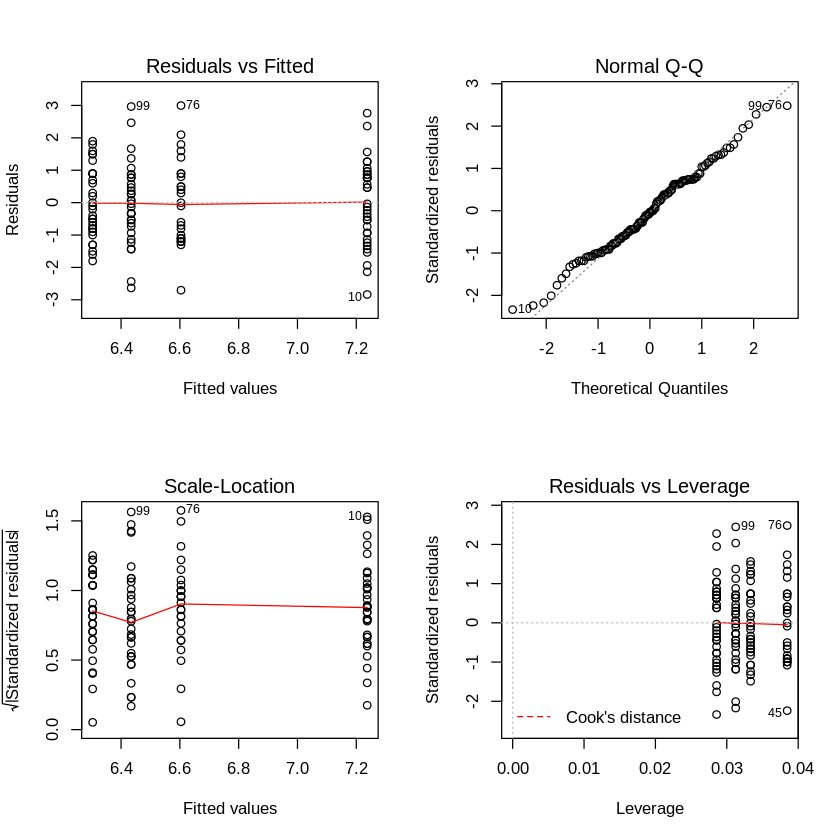

In [32]:
# Residual analysis produces 4 plots by default.
par(mfrow = c(2,2)) # prepares an plot device layout with 2 columns and 2 rows (4 plots)
plot(mod1)
par(mfrow = c(1,1))

shapiro.test(mod1$resid)

Independence of measurements can be assessed by plotting a response variable's values in their order of measurements, or with a **Serial Correlation Plot** using the `acf` function (assuming the the order of measurements of `Petal_length` in the table corresponds to the order of measurements taken on each `Date`. If the autocorrelation function ACF is within the blue dotted lines for lags > 0, the measurements are not significantly autocorrelated (or dependent).

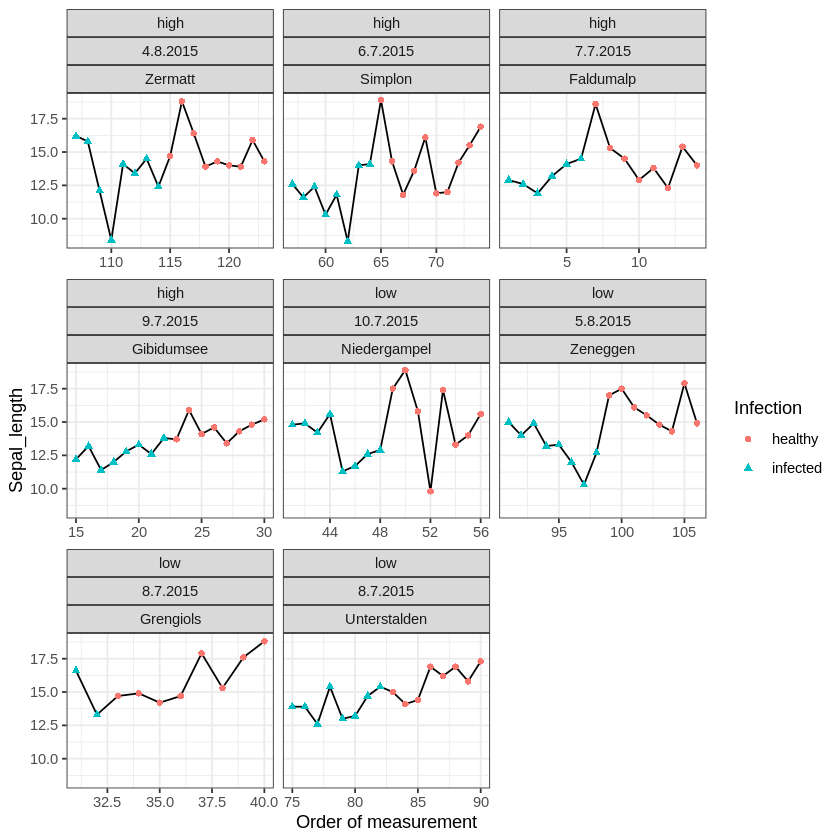

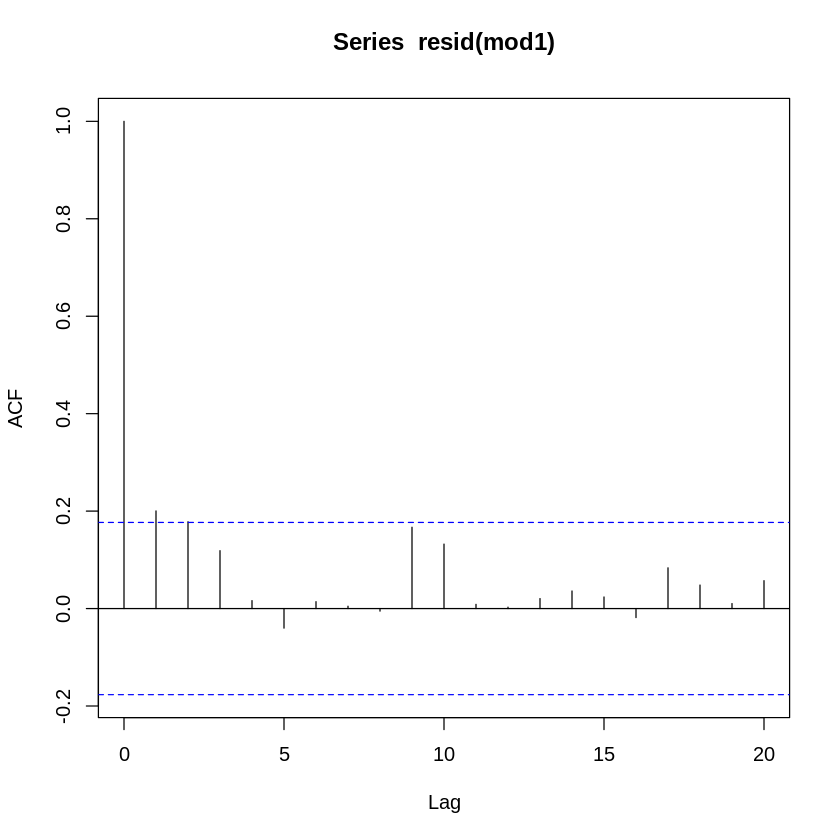

In [36]:
ggplot(morph, aes(seq_along(Sepal_length), Sepal_length)) + 
  geom_line() + geom_point(aes(color = Infection, shape = Infection)) +
  labs(x = "Order of measurement") +
  facet_wrap(~ Elevation + Date + Population, scales = "free_x") + 
  theme_bw()

acf(resid(mod1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Are the assumptions of normality, constant variance and independence of the residuals met?


***
### Variable transformations
Apart from interaction effects, transformations of the resonse Y or the numerical predictors X often help to improve model fit, at the expense of interpretability of the fitted model parameters (estimated effect sizes). There are the following commonly used **first-aid transformations**.

- for *positive counts*:               `X <- sqrt(X)`
- for *positive continuous variables*: `X <- log(X)`
- for *fractions* [0,1]:               `X <- asin(sqr(X))`

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Now try to apply a transformation to the response.
* Does the model fit improve?

In [0]:
## Create your model here

***
### Compare nested models
Complex models are *less parsimonious* (more parameters need to be estimated). If a complex model can be replaced by a simpler model with an equally good fit, one would always **prefer the simpler model**. 

You can formally test two **nested** models (i.e. fitted to the same data, one model with one or more additional model terms) using the `anova` function. If the F test turns out significant, the **larger / complex** model (in our case, the model including the interaction term) is a **better** fit to the data, and should thus be preferred over the smaller / simpler model.

In [37]:
mod.large <- aov(Petal_length ~ Infection * Elevation, data = morph)
mod.small <- aov(Petal_length ~ Infection + Elevation, data = morph)
print(anova(mod.large,mod.small))

  Res.Df      RSS Df Sum of Sq        F     Pr(>F)
1    119 180.4332 NA        NA       NA         NA
2    120 189.6815 -1 -9.248309 6.099481 0.01494049


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Would you choose `mod.large` or `mod.small`?

Also have a look at the `step` function that allows to identify an optimal model among a much more extensive range of possible models. It does so by adding *one* model term to (or remove one model term from) an initial model (`mod.small` in this case). All single term additions and drops that are within the `scope` are tested, and the model with the smallest [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) value is kept. These steps are iterated until the AIC does not decrease anymore, and the final model is returned.

Start:  AIC=59.28
Petal_length ~ Infection + Elevation

                       Df Sum of Sq    RSS    AIC
+ Elevation:Population  6    39.369 150.31 42.665
+ Infection:Elevation   1     9.248 180.43 55.131
- Elevation             1     2.782 192.46 59.070
<none>                              189.68 59.279
- Infection             1     5.250 194.93 60.637

Step:  AIC=42.67
Petal_length ~ Infection + Elevation + Elevation:Population

                       Df Sum of Sq    RSS    AIC
+ Infection:Elevation   1     8.493 141.82 37.512
<none>                              150.31 42.665
- Infection             1     6.362 156.68 45.765
- Elevation:Population  6    39.369 189.68 59.279

Step:  AIC=37.51
Petal_length ~ Infection + Elevation + Elevation:Population + 
    Infection:Elevation

                       Df Sum of Sq    RSS    AIC
<none>                              141.82 37.512
- Infection:Elevation   1     8.493 150.31 42.665
- Elevation:Population  6    38.614 180.43 55.131


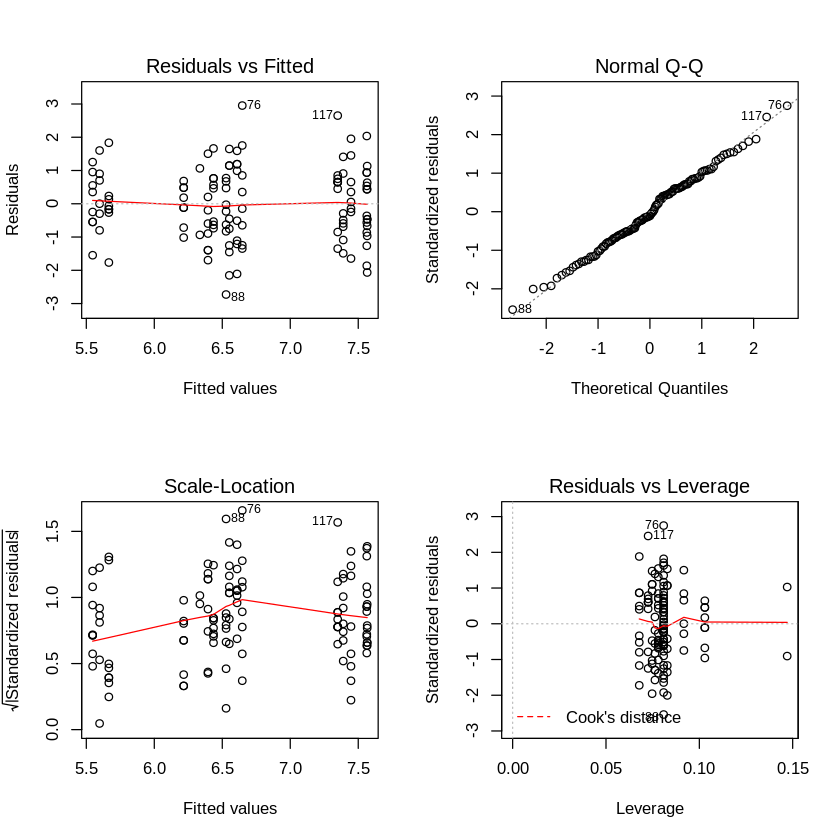

In [50]:
mod.best <- step(object = mod.small, 
                 scope = list(lower = Petal_length ~ 1, 
                              upper = Petal_length ~ Infection * Elevation + Elevation/Population), 
                 direction = "both")

par(mfrow = c(2,2))
plot(mod.best)
par(mfrow = c(1,1))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Which model is selected? (don't forget to check the residuals of this model as well!)

***
### Contrasts
A [**contrast**](https://en.wikipedia.org/wiki/Contrast_(statistics)) is a specific hypothesis to be tested. Imagine that you are not only interested in an *overall* difference in `Petal_length` between `Population`s (or put differently: an overall effect of `Population` on `Petal_length`), but you want to test whether a *specific* population is different from another (or a specific treatment different from a control). You can think of them as t-tests carried out between specific factor levels. 

You can use **Tukey's Honest Significant Differences** method to test for differences in the response variable between *all* pairs of factor levels. This method is implemented in the `TukeyHSD` function but can be used as an option in the more flexible `glht` function from the [multcomp](https://cran.r-project.org/web/packages/multcomp/vignettes/multcomp-examples.pdf) package. The drawback here is that with many factor levels, you are carrying out a lot of tests, and not all of them answer your questions.




	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = Petal_length ~ Population, data = morph)

Linear Hypotheses:
                                 Estimate Std. Error t value Pr(>|t|)    
Gibidumsee - Faldumalp == 0       0.76964    0.42716   1.802  0.61863    
Grengiols - Faldumalp == 0        0.09714    0.48327   0.201  1.00000    
Niedergampel - Faldumalp == 0    -0.53661    0.42716  -1.256  0.91216    
Simplon - Faldumalp == 0          0.99603    0.41593   2.395  0.25268    
Unterstalden - Faldumalp == 0     0.44464    0.42716   1.041  0.96677    
Zeneggen - Faldumalp == 0         1.36339    0.42716   3.192  0.03689 *  
Zermatt - Faldumalp == 0          0.75714    0.42125   1.797  0.62202    
Grengiols - Gibidumsee == 0      -0.67250    0.47052  -1.429  0.84085    
Niedergampel - Gibidumsee == 0   -1.30625    0.41267  -3.165  0.03993 *  
Simplon - Gibidumsee == 0         0.22639    0.40105   0.564  0.99920    
Unte

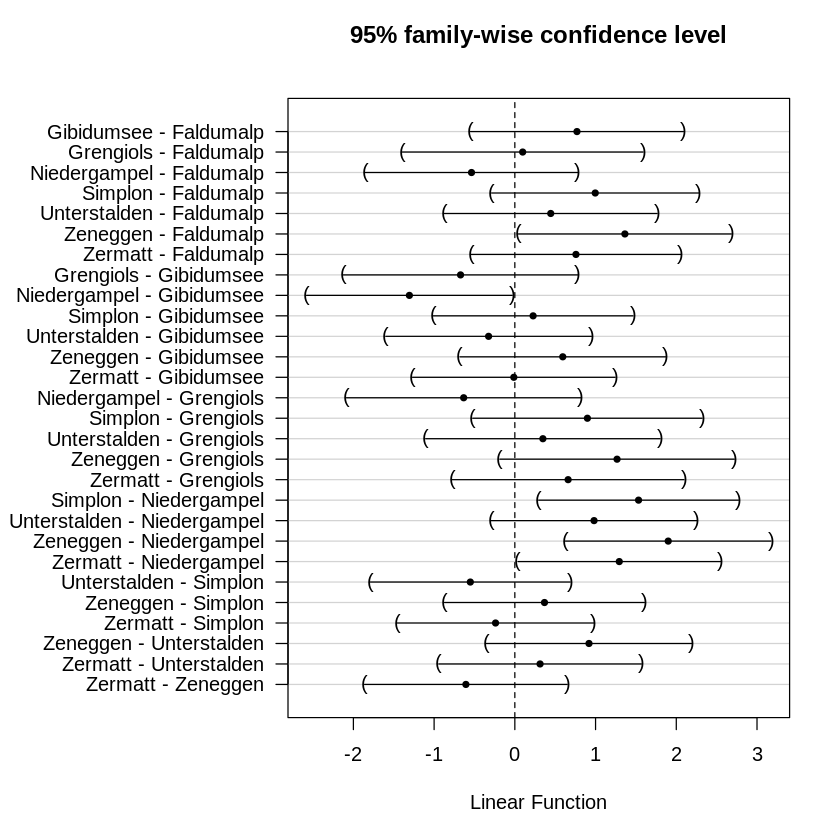

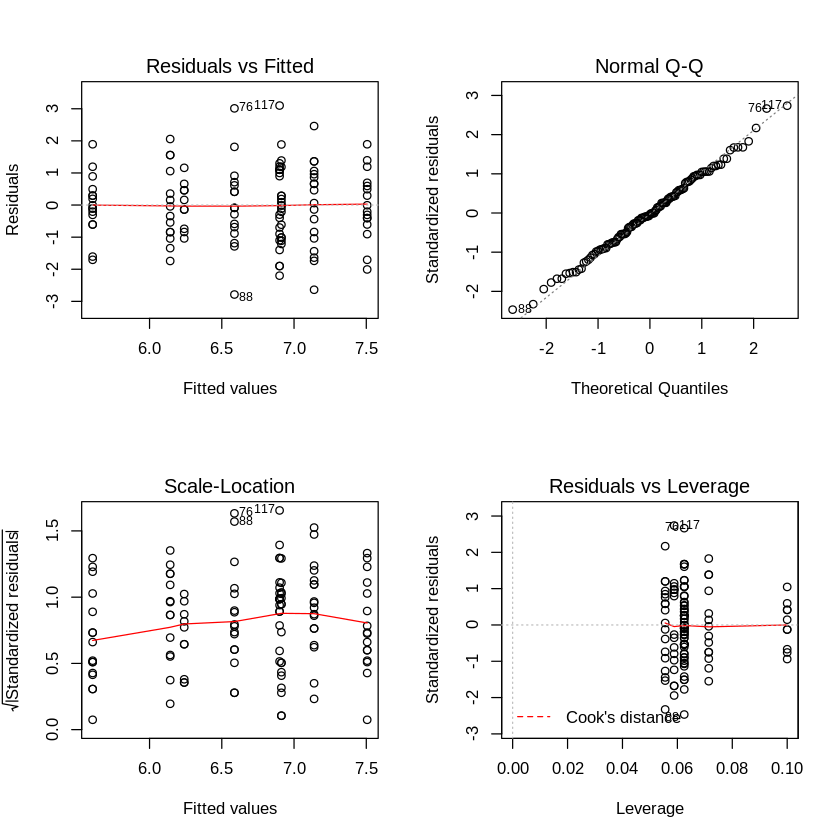

In [106]:
# fit a model of Petal_length and Population
mod2 <- aov(Petal_length ~ Population, data = morph)

# perform tests for all pairwise comparisons of populations
tukey <- glht(mod2, linfct = mcp(Population = "Tukey"))
# equivalent: tukey <- TukeyHSD(mod2, which = "Population")

# tabular output
summary(tukey)

# graphical output
oldmar <- par()$mar # get default margins
par(mar = c(5.1, 12, 4.1, 2.1)) # give more left margin
plot(tukey)
par(mar = oldmar) # reset margins to default

# residual analysis for mod2
par(mfrow=c(2,2))
plot(mod2)
par(mfrow=c(2,2))

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
* Which population pair shows the largest difference in `Petal_length`?

The `glht` function can do much more. It allows you to control which comparisons (tests) should be carried out. Each comparison is a separate test on the same dataset, therefore we have a **multiple testing problem**. The function `summary` on `glht` objects allows to set which p-value correction method should be used to correct for the multiple testing. The use of `glht` for specific contrasts requires the definition of a **contrast matrix**. It is a bit tricky to set up, but try to understand the following example, and you will be able to set specific contrasts that exactly match your research questions, while accounting for the multiple testing involved. These contrasts can be pairwise comparisons, but can also be more complex, as in the next example.

Let us now test whether `Petal_length` is significatly different between 
- Zeneggen and (Faldumalp and Grengiols)
- Zermatt and Niedergampel
- Zermatt and Zeneggen
- Zeneggen and Unterstalden
- Zeneggen and Grengiols

Follow these *rules* to create the **contrast matrix** *K*
- use sensible rownames for each contrast (will appear in the summary)
- columns correspond to the factor level (in the same order as `levels(<factor>)`, alphabetical by default)
- set the coefficient to `0` if a level is not used in a contrast
- use positive coefficients for levels in the first group and negative coefficients for levels in the second group
- levels in the first and second group *must* add up to 1 and -1, respectively
- each row *must* add up to zero

In [114]:
# define the contrast matrix for specific contrasts of interest
#              first  -  second                 Fal, Gib, Gre, Nie, Sim, Unt, Zen, Zer
K <- rbind("Zeneggen - Faldumalp+Grengiols"= c(-1/2,   0,-1/2,   0,   0,   0,   1,   0),
           "Zermatt - Niedergampel"        = c(   0,   0,   0,  -1,   0,   0,   0,   1),
           "Zermatt - Zeneggen"            = c(   0,   0,   0,   0,   0,   0,  -1,   1),
           "Zeneggen - Unterstalden"       = c(   0,   0,   0,   0,   0,  -1,   1,   0),
           "Zeneggen - Grengiols"          = c(   0,   0,  -1,   0,   0,   0,   1,   0))

# tabular output
# "single-step" is the default p-value correcton method
# The "BH" (Bonferroni-Holm) method is less conservative and more powerful than "bonferroni"
summary(specific <- glht(mod2, linfct = mcp(Population = K)), test = adjusted("single-step"))

# corresponding t-tests for comparison
t.test(morph$Petal_length[morph$Population %in% c("Zeneggen")],
       morph$Petal_length[morph$Population %in% c("Faldumalp","Grengiols")])
t.test(morph$Petal_length[morph$Population %in% "Zermatt"],
       morph$Petal_length[morph$Population %in% "Niedergampel"])
t.test(morph$Petal_length[morph$Population %in% "Zermatt"],
       morph$Petal_length[morph$Population %in% "Zeneggen"])
t.test(morph$Petal_length[morph$Population %in% "Zeneggen"],
       morph$Petal_length[morph$Population %in% "Unterstalden"])
t.test(morph$Petal_length[morph$Population %in% "Zeneggen"],
       morph$Petal_length[morph$Population %in% "Grengiols"])


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: User-defined Contrasts


Fit: aov(formula = Petal_length ~ Population, data = morph)

Linear Hypotheses:
                                    Estimate Std. Error t value Pr(>|t|)   
Zeneggen - Faldumalp+Grengiols == 0   1.3148     0.3789   3.470  0.00324 **
Zermatt - Niedergampel == 0           1.2937     0.4066   3.182  0.00793 **
Zermatt - Zeneggen == 0              -0.6062     0.4066  -1.491  0.42525   
Zeneggen - Unterstalden == 0          0.9187     0.4127   2.226  0.10620   
Zeneggen - Grengiols == 0             1.2662     0.4705   2.691  0.03368 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% c("Zeneggen")] and morph$Petal_length[morph$Population %in% c("Faldumalp", "Grengiols")]
t = 3.9729, df = 30.955, p-value = 0.0003946
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.6437513 2.0020821
sample estimates:
mean of x mean of y 
 7.506250  6.183333 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Zermatt"] and morph$Petal_length[morph$Population %in% "Niedergampel"]
t = 3.039, df = 26.974, p-value = 0.005224
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4202116 2.1672884
sample estimates:
mean of x mean of y 
  6.90000   5.60625 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Zermatt"] and morph$Petal_length[morph$Population %in% "Zeneggen"]
t = -1.3619, df = 28.964, p-value = 0.1837
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.5167183  0.3042183
sample estimates:
mean of x mean of y 
  6.90000   7.50625 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Zeneggen"] and morph$Petal_length[morph$Population %in% "Unterstalden"]
t = 2.1539, df = 28.434, p-value = 0.03987
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04560124 1.79189876
sample estimates:
mean of x mean of y 
  7.50625   6.58750 



	Welch Two Sample t-test

data:  morph$Petal_length[morph$Population %in% "Zeneggen"] and morph$Petal_length[morph$Population %in% "Grengiols"]
t = 3.6436, df = 23.761, p-value = 0.001305
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5485989 1.9839011
sample estimates:
mean of x mean of y 
  7.50625   6.24000 


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
Compare results of the specific contrasts to the TukeyHSD results and the t-test results. 
- Why is there a difference between the specific contrasts results and the TukeyHSD results?
- Why is it better to specify specific contrasts rather than carry out multiple t-tests?

***
## Multivariate Analyses

[Multivariate analysis](https://en.wikipedia.org/wiki/Multivariate_analysis) is a broad term that includes methods such as **Clustering analysis**, **Principal Component Analysis** (PCA), or **Linear Discriminant Analysis** (LDA).

We will use a data set from my Master Thesis that contains morphological measurements on 10 leaf characters in eight [*Dalbergia*](https://en.wikipedia.org/wiki/Dalbergia) rosewood species from Madagascar. 

Let us read the data and get an overview. Note the use of `row.names` here: it automatically assigns row names of the resulting `data.frame` as the values stored in the column `ID`, and removes `ID` from the set of variables.

In [51]:
d.mis <- read.csv("https://raw.githubusercontent.com/scrameri/Umweltbiologie/master/Multivariate.csv", row.names = "ID")
str(d.mis)

'data.frame':	126 obs. of  12 variables:
 $ Species            : Factor w/ 8 levels "Species1","Species2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Region             : Factor w/ 2 levels "North","South": 1 1 1 1 1 1 1 1 1 1 ...
 $ leaf.length        : num  66.7 74.9 108.2 60.7 81 ...
 $ leaflet.length     : num  6.7 10.34 9.83 11.85 11.97 ...
 $ leaflet.width      : num  2.75 4.96 6.15 5.25 5.52 ...
 $ leaflet.area       : num  14.3 41.9 48 50.6 48.1 ...
 $ leaflet.upper.hairy: int  3 3 3 3 3 3 3 3 3 3 ...
 $ leaflet.lower.hairy: int  3 3 3 NA 3 3 3 3 3 3 ...
 $ leaf.hairy         : int  3 3 3 3 3 3 3 3 3 3 ...
 $ leaflet.shape1     : num  0.031349 -0.029322 -0.127907 -0.001541 -0.000669 ...
 $ leaflet.shape2     : num  0.00889 0.00466 0.01281 -0.00471 0.00108 ...
 $ length.width       : num  2.49 2.1 1.63 2.26 2.13 ...


Since the dataset does not have too many variables, we can produce all pairwise plots using `ggparis` from the [*GGally*](https://cran.r-project.org/web/packages/GGally/index.html) package.

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 12 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 7 rows containing missing value

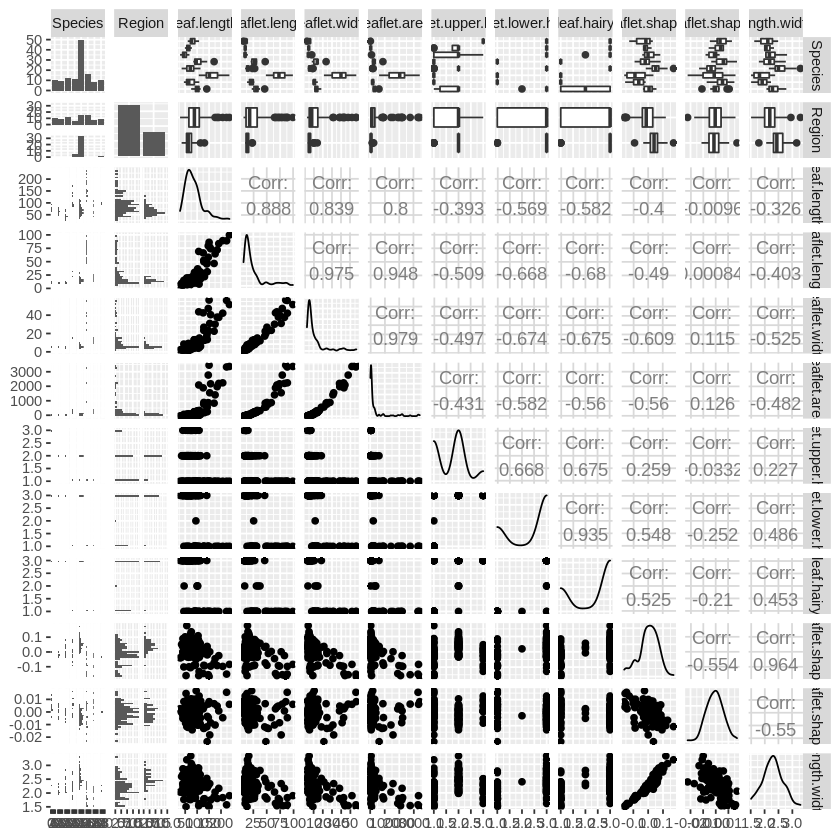

In [52]:
gp <- ggpairs(data = d.mis)
print(gp)

You see that some of the variables are highly *correlated* among each other. While this is a potential problem for linear models, this is not a problem for many multivariate techniques.

### Data imputation
Most multivariate techniques cannot handle missing values. Bear this in mind when designing experiments and measuring data, and make sure to collect data that is *as complete as possible*.

One way to get around the missingness problem is to do a **Complete Case Analysis** by removing any individual with missing data. This may lead to loss of many individuals (most of the data) if missingness is distributed randomly accross individuals.

In the case of large datasets such as genetic datasets, one often has little data for some variables (genetic loci) for technical reasons. These loci might however be highly correlated to other loci with less missingness, and can thus be entirely removed from analysis without much information loss. 

However, before you remove any variable with one or more missing values, it makes sense to remove individuals that have few overall data, because that might 'save' many variables from being excluded at the expense of just a few excluded individuals.


Let us check how much missingness our dataset has, using a *self-written* **function** that computes the proportion of missing data.

Think of `x` as a vector of numbers, e.g. one column or one row in the dataset. The missingness is a function of `x`, and computed as the `sum` of `NA` values in `x` divided by the number of observations in `x`. Such a function is only slightly more complex than standard functions such as `mean`, but it could be an arbitrarily complex function with many intermediate steps and variables.

In [0]:
# define the function that computes the percentage of missing values in a numeric vector
missingness <- function(x) {sum(is.na(x))/length(x)}

#### the apply function family
Let us now apply this function to all columns, and all rows, to identify how much missingness these have. For such tasks, we use the `apply` familiy of functions. Have a look at the manuals for `apply`, `sapply`, `lapply` and `tapply`, these can be quite useful and save quite a lot of coding.

The function `apply` takes a `data.frame` `X` as input, a `MARGIN` specification, and *applies* the function specified by the `FUN` argument to *each* element of the data subset defined by `MARGIN`. The output of `apply` can be a single value, a named vector or a matrix, depending on the `MARGIN` and `FUN` employed.

`MARGIN` can be set as
- `1` for "apply function over each row (returns one value per individuals)"
- `2` for "apply function over each column (returns one value output per variables)"
- `c(1,2)` for "apply function over rows and columns (returns a matrix)"


By the way: any further arguments that are taken by `FUN` can be passed as additional arguments, as indicated by the `...` in the function definition. If you wanted to apply the `mean` function to get column means, you could set `FUN = mean, na.rm = TRUE` to override the default behaviour that returns `NA` if there are missing values.

In [53]:
print(apply(X = d.mis[,-c(1:2)], MARGIN = 2, FUN = mean))

        leaf.length      leaflet.length       leaflet.width        leaflet.area 
       8.676375e+01        2.400057e+01        1.136325e+01        3.511679e+02 
leaflet.upper.hairy leaflet.lower.hairy          leaf.hairy      leaflet.shape1 
                 NA                  NA                  NA        2.622819e-03 
     leaflet.shape2        length.width 
      -6.770812e-04        2.286210e+00 


In [54]:
print(apply(X = d.mis[,-c(1:2)], MARGIN = 2, FUN = mean, na.rm = TRUE))

        leaf.length      leaflet.length       leaflet.width        leaflet.area 
       8.676375e+01        2.400057e+01        1.136325e+01        3.511679e+02 
leaflet.upper.hairy leaflet.lower.hairy          leaf.hairy      leaflet.shape1 
       1.702479e+00        2.447368e+00        2.361345e+00        2.622819e-03 
     leaflet.shape2        length.width 
      -6.770812e-04        2.286210e+00 


You can now combine `apply` with the self-written function `missingness` as follows (once over individuals, once over variables):

In [0]:
mis.rows <- apply(X = d.mis, MARGIN = 1, FUN = missingness) # MARGIN = 1 computes over *rows*
mis.cols <- apply(X = d.mis, MARGIN = 2, FUN = missingness) # MARGIN = 2 computes over *columns*

# this sorts the individual and variable missingness and shows the 10 instances with highest missingness
print(head(sort(mis.rows, decreasing = TRUE), n = 10))
print(head(sort(mis.cols, decreasing = TRUE), n = 10))

     SH568      SH573      SH052      SH386      SH455      SH217      SH002 
0.16666667 0.16666667 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 
     SH279      SH320      SH347 
0.08333333 0.08333333 0.08333333 
leaflet.lower.hairy          leaf.hairy leaflet.upper.hairy             Species 
         0.09523810          0.05555556          0.03968254          0.00000000 
             Region         leaf.length      leaflet.length       leaflet.width 
         0.00000000          0.00000000          0.00000000          0.00000000 
       leaflet.area      leaflet.shape1 
         0.00000000          0.00000000 


We see that one variable has nearly 10% missing data, while two individuals have over 15% missingness. Excluding one out of 10 variables would throw away much more information than excluding two out of 126 individuals that likely contribute to the observed missingness.

![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
To which `Species` do these individuals with high missingness belong, and can we remove these individuals without losing data for a given `Species`?

In [0]:
# write your code here

If the data table still contains missing values after removing individuals or/and variables with little data, these can be replaced by some unbiased values via **data imputation**. There are many sophisticated methods to do this. One simple method is to impute **variable means**.

BEWARE: be cautios when imputing, and always bear in mind how much missingness your data has. Everitt & Hothorn (2011) An Introduction to Applied Multivariate Analysis with R, Springer, say:
"Imputing an observed variable mean for a variable with missing values preserves the observed sample means but distorts the covariance matrix [...], biasing estimated variances and covariances towards zero. [...] one should always bear in mind that the imputed values are not real measurements. We do not get something for nothing! And if there is a substantial proportion of individuals with large amounts of missing data, one should clearly question whether any form of statistical analysis is worth the bother."


![Question](https://img.icons8.com/flat_round/64/000000/question-mark.png)
- Can you write a function that replaces all `NA` values in a vector by the `mean` of that vector? Hint: use the `return` function to return the imputed vector.
- Can you apply that function to all variables with missing data, and assign the output to a `data.frame` named `d.imp`?

In [56]:
# Write your function and application here

# Test your function on this test vector (yourfunction(tes))
test <- c(1.1,3.2,6.4,NA,3.6)
print(mean(test, na.rm = TRUE))

# Apply your function to all numeric columns of d.mis, and assign the output to d.imp

[1] 3.575


***
### Data Aggregation
It may be of interest to compute a **summary statistic** such as the `median` of *all* numeric variables *per species*. This would allow for a quick comparison between species.

Of course, one could do subsets of the dataset for each species to calculate the summary statistic, or apply the `tapply` function for each variable, but that takes lines of code for each species or variable, respectively. There is an even more powerful function to do such calculations in *one* line of code. Meet the `aggregate` function: it takes a `data.frame` of numeric variables as input, and applies a specified function `FUN` to *subsets* of each variable. The subsets are defined by the `by` argument, and can include one or more factor variables, which *have* to be specified as a *list*.


In [63]:
aggregate(x = d.mis[,-c(1,2)], by = list(d.mis$Species), FUN = median, na.rm = TRUE)

# It even works if we want to summarize (aggregate) the data by two factors'
aggregate(x = d.mis[,-c(1,2)], by = list(d.mis$Species, d.mis$Region), FUN = median, na.rm = TRUE)

Group.1,leaf.length,leaflet.length,leaflet.width,leaflet.area,leaflet.upper.hairy,leaflet.lower.hairy,leaf.hairy,leaflet.shape1,leaflet.shape2,length.width
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Species1,76.51950,11.908497,5.770208,49.31762,3,3,3,-0.0154314886,0.0033535697,2.116620
Species2,62.13850,9.862026,4.711305,36.87333,2,3,3,-0.0239559186,0.0038645582,2.053046
Species3,43.58150,9.504244,4.186303,31.44902,2,3,3,-0.0007905552,-0.0009983477,2.173560
Species4,96.07900,27.288135,13.974252,283.73605,1,1,1,-0.0200549338,0.0060013393,2.183407
Species5,71.40075,14.946589,5.622025,65.14650,2,3,3,0.0510212546,-0.0037543992,2.499225
Species6,151.43225,72.774679,39.747235,2031.35687,1,1,1,-0.0889206352,-0.0012243232,1.816990
Species7,64.87325,21.047738,10.510562,159.08677,1,1,1,-0.0632148654,0.0053507570,1.913285
Species8,100.39450,31.154677,12.977832,282.73342,2,3,2,0.0060185452,-0.0002942781,2.283488


Group.1,Group.2,leaf.length,leaflet.length,leaflet.width,leaflet.area,leaflet.upper.hairy,leaflet.lower.hairy,leaf.hairy,leaflet.shape1,leaflet.shape2,length.width
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Species1,North,76.51950,11.908497,5.770208,49.31762,3,3,3,-0.0154314886,0.0033535697,2.116620
Species2,North,62.13850,9.862026,4.711305,36.87333,2,3,3,-0.0239559186,0.0038645582,2.053046
Species3,North,43.58150,9.504244,4.186303,31.44902,2,3,3,-0.0007905552,-0.0009983477,2.173560
Species4,North,97.68150,30.811920,14.597873,305.00571,1,1,1,-0.0250633614,0.0006146814,2.161755
Species5,North,89.90350,17.484496,6.556438,87.03778,2,3,3,0.0598015504,-0.0060843972,2.593516
Species6,North,151.43225,72.774679,39.747235,2031.35687,1,1,1,-0.0889206352,-0.0012243232,1.816990
Species7,North,64.87325,21.047738,10.510562,159.08677,1,1,1,-0.0632148654,0.0053507570,1.913285
Species8,North,101.27400,31.540146,13.417724,299.48748,2,3,2,0.0190764710,-0.0004563613,2.313541
Species4,South,96.07900,21.950483,9.892048,161.86073,1,1,1,0.0005048062,0.0061813819,2.297106


***
### Plot multivariate data
There are a number of special plots designed to visualize large multivariate datasets. One of them is the **Co-Plot**. A Co-Plot displays scatterplots of two variables, but separately for different states of up to two other variables.

The `coplot` function takes the variables to be displayed as a formula:
- `coplot(y ~ x | separated_by_x + separated_by_y, data = data)`


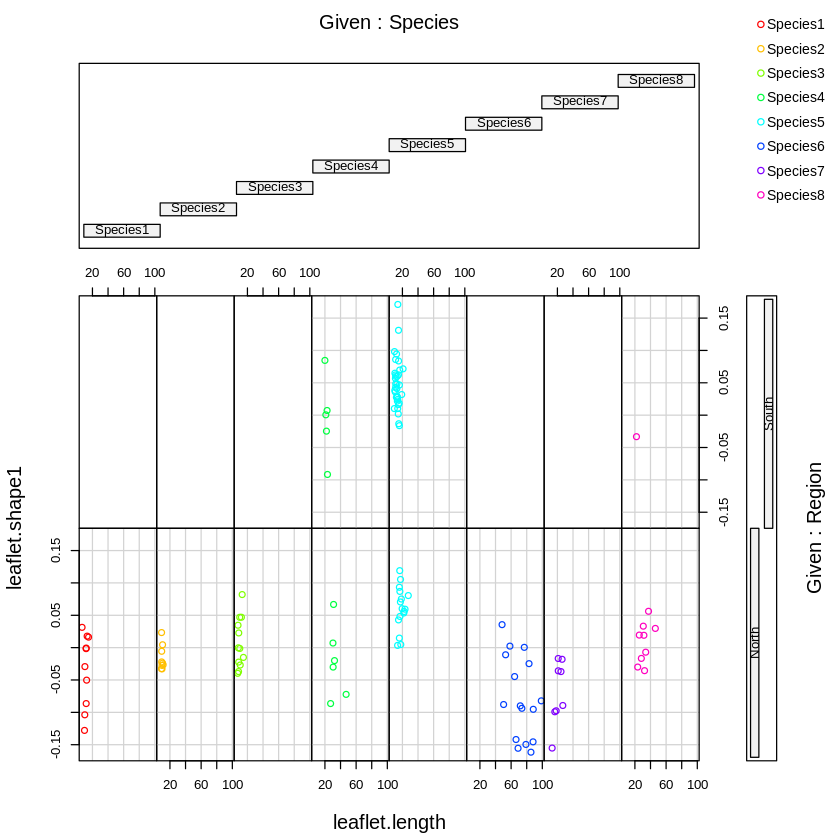

In [70]:
impute <- function(x) {x[is.na(x)] <- mean(x, na.rm = TRUE) ; return(x)}
d.imp <- data.frame(d.mis[,1:2], apply(d.mis[,-c(1,2)], 2, impute))

## Co-Plot
col <- rainbow(n = nlevels(d.imp$Species)) # color vector for the 8 Species

coplot(leaflet.shape1 ~ leaflet.length | Species + Region, data = d.imp, 
       col = col[d.imp$Species])  # note the use of col
legend("topright",levels(d.imp$Species),pch = 1, col = col, 
       xpd = TRUE, bty = "n", cex = 0.7)

Now we already see that Species1, 2, 3 and 5 are similar with respect to leaflet.length and leaflet.shape1, or that Species 6 has by far the longest leaflets. But what about overall similarity based on all the data (could be thousands of variables, think e.g. of next-generation sequencing data)? This is a **dimensionality problem**, which is where **Principal Components Analysis** (PCA) can help.

' PCA can only handle NUMERIC data'
d.pca <- d.imp[,numericvars]

' We can still keep the ID by assigning the character vector d.imp$ID to 
  the rownames of d.pca. Like that, the downstream results table still have IDs.'
rownames(d.pca) # default rownames are set to 1:nrow(data.frame)
rownames(d.pca) <- d.imp$ID # assign ID (must be unique)
rownames(d.pca) 

## carry out PCA using the prcomp() function
' In PCA, all variables are usually centered (around zero, by subtracting their mean).
  The question is whether one should scale the variables (divide by their sd).
  If we deal with variables that measure very different things, e.g. size and shape,
  (very different standard deviations, e.g. in millimeters vs. unitless), it is very 
  important to scale the variables to unit variance.
'

sort(apply(X = d.pca, MARGIN = 2, FUN = var), decreasing = TRUE) 
' leaflet.area has 10^10 times the variance of leaflet.shape2 but that ist due to the scale of measurement, not due to the amount of information
'

pca <- prcomp(x = d.pca, center = TRUE, scale. = TRUE) # don't forget the "."!
' same as prcomp(x = scale(d.pca, center = T, scale = T), center = F, scale. = F)'

str(pca)
' In a PCA, there are 3 important results to look at.
  - $x gives the value at each PC for each individual (so-called PCA SCORES)
  - $sdev contains information on the amount of explained VARIANCE per PC
  - $rotation contains variable LOADINGS (how much each original variable contributs 
    to each PC)
'

## Links
ANOVA Teaching Notes by Dr. Lukas Meier, Senior Scientist at the Seminar for Statistics
- https://stat.ethz.ch/~meier/teaching/anova/